In [1]:
# v2: 1.102507841834652
# v9 : del area_floor
# 10: remove 1099
# 11: dayweek
# 12 : del bil_median
# 13 : leak data update
# 14 : site-0 unit correction
# sg filter

#v3 : add diff2 (bug)
#v4 : add diff2
#v5 : black 10

In [2]:
black_day = 10
outlier = False
rescale = False

debug=False
num_rounds = 200

clip0=False # minus meter confirmed in test(site0 leak data)

folds = 3 # 3, 6, 12
# 6: 1.1069822104487446
# 3: 1.102507841834652
# 12: 1.1074824417420517

use_ucf=False
ucf_clip=False

ucf_year = [2017, 2018] # ucf data year used in train 

predmode='all' # 'valid', train', 'all'

In [3]:
import gc
import os
from pathlib import Path
import random
import sys

from tqdm import tqdm_notebook as tqdm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import display, HTML

# --- models ---
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb

from sklearn.metrics import mean_squared_error

In [4]:
os.listdir('../input')

['ashrae-energy-prediction',
 'ashrae-feather-format-for-fast-loading',
 'site-meter-median-bland-by-leak',
 'ashrae-leak-data-station']

In [5]:
# Original code from https://www.kaggle.com/gemartin/load-data-reduce-memory-usage by @gemartin
# Modified to support timestamp type, categorical type
# Modified to add option to use float16 or not. feather format does not support float16.
from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.api.types import is_categorical_dtype

def reduce_mem_usage(df, use_float16=False):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        if is_datetime(df[col]) or is_categorical_dtype(df[col]):
            # skip datetime type or categorical type
            continue
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if use_float16 and c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [6]:
zone_dict={0:4,1:0,2:7,3:4,4:7,5:0,6:4,7:4,8:4,9:5,10:7,11:4,12:0,13:5,14:4,15:4} 

def set_local(df):
    for sid, zone in zone_dict.items():
        sids = df.site_id == sid
        df.loc[sids, 'timestamp'] = df[sids].timestamp - pd.offsets.Hour(zone)

In [7]:
!ls ../input

ashrae-energy-prediction		ashrae-leak-data-station
ashrae-feather-format-for-fast-loading	site-meter-median-bland-by-leak


# Fast data loading

This kernel uses the preprocessed data from my previous kernel, [
ASHRAE: feather format for fast loading](https://www.kaggle.com/corochann/ashrae-feather-format-for-fast-loading), to accelerate data loading!

In [8]:
%%time
root = Path('../input/ashrae-feather-format-for-fast-loading')
#root_black = Path('../input/ashrae-local-datatime-and-black-count')
train_df = pd.read_feather(root/'train.feather')
#train_df_black = pd.read_feather(root_black/'train_black.feather')
weather_train_df = pd.read_feather(root/'weather_train.feather')
#weather_test_df = pd.read_feather(root/'weather_test.feather')
building_meta_df = pd.read_feather(root/'building_metadata.feather')

root_median = Path('../input/site-meter-median-bland-by-leak')
df_groupNum_median = pd.read_pickle(root_median/'df_groupNum_median.pickle')


/opt/conda/lib/python3.6/site-packages/pandas/io/feather_format.py:117: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_feather(path, columns=columns, nthreads=int_use_threads)


CPU times: user 2.31 s, sys: 922 ms, total: 3.23 s
Wall time: 6.99 s


/opt/conda/lib/python3.6/site-packages/pyarrow/pandas_compat.py:751: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


In [9]:
building_meta_df = building_meta_df.merge(train_df[['building_id','meter']].drop_duplicates(), on='building_id')

# Set group # (site-meter) for training models

In [10]:
building_meta_df['groupNum_train'] = building_meta_df['site_id'].astype('int')*10 + building_meta_df['meter'].astype('int')

In [11]:
building_meta_df

,site_id,building_id,primary_use,square_feet,year_built,floor_count,meter,groupNum_train
0,0,0,Education,7432,2008.0,NaN,0,0
1,0,1,Education,2720,2004.0,NaN,0,0
2,0,2,Education,5376,1991.0,NaN,0,0
3,0,3,Education,23685,2002.0,NaN,0,0
4,0,4,Education,116607,1975.0,NaN,0,0
...,...,...,...,...,...,...,...,...
2375,15,1444,Entertainment/public assembly,19619,1914.0,NaN,0,150
2376,15,1445,Education,4298,NaN,NaN,0,150
2377,15,1446,Entertainment/public assembly,11265,1997.0,NaN,0,150
2378,15,1447,Lodging/residential,29775,2001.0,NaN,0,150


# remove buildings

In [12]:
train_df = train_df [ train_df['building_id'] != 1099 ]

In [13]:
building_meta_df['floor_area'] = building_meta_df.square_feet / building_meta_df.floor_count

# Leak Data loading and concat

# Site specific holiday

In [14]:
import holidays

en_holidays = holidays.England()
ir_holidays = holidays.Ireland()
ca_holidays = holidays.Canada()
us_holidays = holidays.UnitedStates()

def add_holiyday(df_weather):
    en_idx = df_weather.query('site_id == 1 or site_id == 5').index
    ir_idx = df_weather.query('site_id == 12').index
    ca_idx = df_weather.query('site_id == 7 or site_id == 11').index
    us_idx = df_weather.query('site_id == 0 or site_id == 2 or site_id == 3 or site_id == 4 or site_id == 6 or site_id == 8 or site_id == 9 or site_id == 10 or site_id == 13 or site_id == 14 or site_id == 15').index

    df_weather['IsHoliday'] = 0
    df_weather.loc[en_idx, 'IsHoliday'] = df_weather.loc[en_idx, 'timestamp'].apply(lambda x: en_holidays.get(x, default=0))
    df_weather.loc[ir_idx, 'IsHoliday'] = df_weather.loc[ir_idx, 'timestamp'].apply(lambda x: ir_holidays.get(x, default=0))
    df_weather.loc[ca_idx, 'IsHoliday'] = df_weather.loc[ca_idx, 'timestamp'].apply(lambda x: ca_holidays.get(x, default=0))
    df_weather.loc[us_idx, 'IsHoliday'] = df_weather.loc[us_idx, 'timestamp'].apply(lambda x: us_holidays.get(x, default=0))

    holiday_idx = df_weather['IsHoliday'] != 0
    df_weather.loc[holiday_idx, 'IsHoliday'] = 1
    df_weather['IsHoliday'] = df_weather['IsHoliday'].astype(np.uint8)

In [15]:
set_local(weather_train_df)
add_holiyday(weather_train_df)

In [16]:
weather_train_df.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,IsHoliday
0,0,2015-12-31 20:00:00,25.000000,6.0,20.0,NaN,1019.700012,0.0,0.0,0
1,0,2015-12-31 21:00:00,24.400000,NaN,21.1,-1.0,1020.200012,70.0,1.5,0
2,0,2015-12-31 22:00:00,22.799999,2.0,21.1,0.0,1020.200012,0.0,0.0,0
3,0,2015-12-31 23:00:00,21.100000,2.0,20.6,0.0,1020.099976,0.0,0.0,0
4,0,2016-01-01 00:00:00,20.000000,2.0,20.0,-1.0,1020.000000,250.0,2.6,1


# Threshold By Black day

In [17]:
# # Count zero streak
train_df_black = train_df.copy()
train_df_black = train_df_black.merge(building_meta_df, on=['building_id', 'meter'], how='left')
train_df_black = train_df_black.merge(weather_train_df, on=['site_id', 'timestamp'], how='left')

train_df_black['black_count']=0

for bid in train_df_black.building_id.unique():
    df = train_df_black[train_df_black.building_id==bid]
    for meter in df.meter.unique():
        dfm = df[df.meter == meter]
        b = (dfm.meter_reading == 0).astype(int)
        train_df_black.loc[(train_df_black.building_id==bid) & (train_df_black.meter == meter), 'black_count'] = b.groupby((~b.astype(bool)).cumsum()).cumsum()

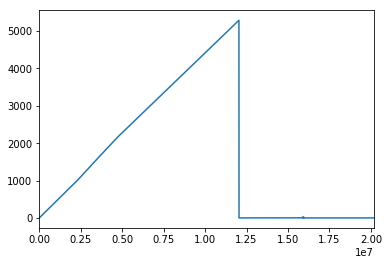

In [18]:
train_df_black[train_df_black.building_id == 954].black_count.plot()

In [19]:
train_df.shape

(20198534, 4)

In [20]:
train_df = train_df.merge(train_df_black[['timestamp','building_id','meter','black_count']], on=['timestamp','building_id','meter'])
train_df = train_df[train_df['black_count'] < 24*black_day].drop('black_count', axis=1)

In [21]:
train_df.shape

(19347775, 4)

In [22]:
del train_df_black
gc.collect()

14

## Removing weired data on site_id 0

As you can see above, this data looks weired until May 20. It is reported in [this discussion](https://www.kaggle.com/c/ashrae-energy-prediction/discussion/113054#656588) by @barnwellguy that **All electricity meter is 0 until May 20 for site_id == 0**. I will remove these data from training data.

It corresponds to `building_id <= 104`.

In [23]:
#building_meta_df[building_meta_df.site_id == 0]

In [24]:
train_df = train_df.query('not (building_id <= 104 & meter == 0 & timestamp <= "2016-05-20")')

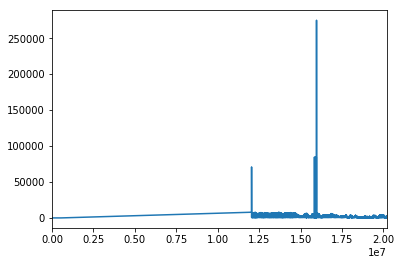

In [25]:
train_df[train_df.building_id == 954].meter_reading.plot()

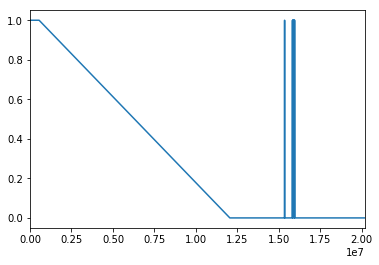

In [26]:
(train_df[train_df.building_id == 954].meter_reading==0).astype(int).plot()

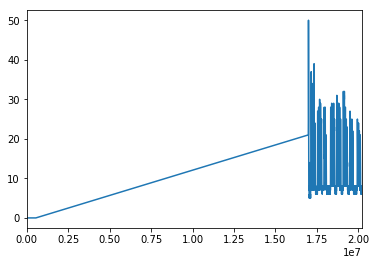

In [27]:
train_df[train_df.building_id == 1221].meter_reading.plot()

In [28]:
train_df = train_df.query('not (building_id == 954 & meter_reading == 0)')
train_df = train_df.query('not (building_id == 1221 & meter_reading == 0)')

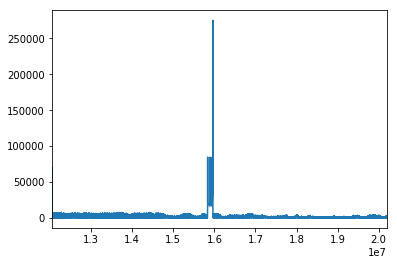

In [29]:
train_df[train_df.building_id == 954].meter_reading.plot()

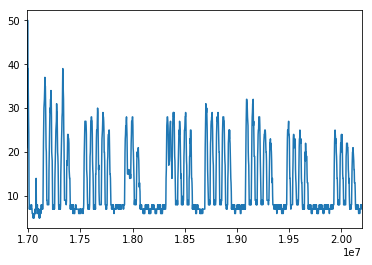

In [30]:
train_df[train_df.building_id == 1221].meter_reading.plot()

# Delete Outliear

In [31]:
funny_bids = [993, 1168,  904,  954,  778, 1021]

print ('before', len(train_df))

if outlier:
    #993
    # or delete
    train_df.loc[(train_df.building_id == 993) & (train_df.meter == 0) & (train_df.meter_reading > 30000), 'meter_reading'] = 31921
    train_df.loc[(train_df.building_id == 993) & (train_df.meter == 1) & (train_df.meter_reading > 90000), 'meter_reading'] =  96545.5

    #1168
    train_df = train_df[((train_df.building_id == 1168) & (train_df.meter == 0) & (train_df.meter_reading >10000)) == False]

    #904
    train_df.loc[(train_df.building_id == 904) & (train_df.meter == 0)& (train_df.meter_reading >10000), 'meter_reading'] = 11306

    #954
    train_df = train_df[((train_df.building_id == 954) & (train_df.meter_reading >10000))==False]

if rescale:
    #778 rescale ?
    train_df.loc[(train_df.building_id == 778) & (train_df.meter == 1), 'meter_reading'] = train_df.loc[(train_df.building_id == 778) & (train_df.meter == 1), 'meter_reading']/ 100
    #
    #1021 rescale ?
    train_df.loc[(train_df.building_id == 1021) & (train_df.meter == 3), 'meter_reading'] = train_df.loc[(train_df.building_id == 1021) & (train_df.meter == 3), 'meter_reading']/ 1000
    #plt.plot(np.log1p(train_df.loc[(train_df.building_id == 1021) & (train_df.meter == 3), 'meter_reading'] ))

train_df = train_df.reset_index()


print ('after', len(train_df))
gc.collect()

before 19237643
after 19237643


0

In [32]:
# for bid in funny_bids:
#     plt.figure(figsize=[20,3])
#     plt.subplot(141)
#     plt.plot(train_df[(train_df.building_id == bid) & (train_df.meter == 0)].meter_reading)
#     plt.subplot(142)
#     plt.plot(train_df[(train_df.building_id == bid) & (train_df.meter == 1)].meter_reading)
#     plt.subplot(143)
#     plt.plot(train_df[(train_df.building_id == bid) & (train_df.meter == 2)].meter_reading)
#     plt.subplot(144)
#     plt.plot(train_df[(train_df.building_id == bid) & (train_df.meter == 3)].meter_reading)
#     plt.title(bid)

# Site-0 Correction

In [33]:
# https://www.kaggle.com/c/ashrae-energy-prediction/discussion/119261#latest-684102
site_0_bids = building_meta_df[building_meta_df.site_id == 0].building_id.unique()
print (len(site_0_bids), len(train_df[train_df.building_id.isin(site_0_bids)].building_id.unique()))
train_df[train_df.building_id.isin(site_0_bids)].head()

105 105


,index,building_id,meter,timestamp,meter_reading
2897217,3169436,7,1,2016-02-29 09:00:00,1857.260010
2897218,3169439,9,1,2016-02-29 09:00:00,590.945007
2897219,3169444,13,1,2016-02-29 09:00:00,1224.099976
2897220,3169446,14,1,2016-02-29 09:00:00,1435.150024
2897221,3169448,15,1,2016-02-29 09:00:00,422.104004


In [34]:
train_df.loc[(train_df.building_id.isin(site_0_bids)) & (train_df.meter==0), 'meter_reading'] = train_df[(train_df.building_id.isin(site_0_bids)) & (train_df.meter==0) ]['meter_reading'] * 0.2931

In [35]:
train_df[train_df.building_id.isin(site_0_bids)].head()

,index,building_id,meter,timestamp,meter_reading
2897217,3169436,7,1,2016-02-29 09:00:00,1857.260010
2897218,3169439,9,1,2016-02-29 09:00:00,590.945007
2897219,3169444,13,1,2016-02-29 09:00:00,1224.099976
2897220,3169446,14,1,2016-02-29 09:00:00,1435.150024
2897221,3169448,15,1,2016-02-29 09:00:00,422.104004


# Data preprocessing

Now, Let's try building GBDT (Gradient Boost Decision Tree) model to predict `meter_reading_log1p`. I will try using LightGBM in this notebook.

In [36]:
train_df['date'] = train_df['timestamp'].dt.date
train_df['meter_reading_log1p'] = np.log1p(train_df['meter_reading'])

# Add time feature

Some features introduced in https://www.kaggle.com/ryches/simple-lgbm-solution by @ryches

Features that are likely predictive:

#### Weather

- time of day
- holiday
- weekend
- cloud_coverage + lags
- dew_temperature + lags
- precip_depth + lags
- sea_level_pressure + lags
- wind_direction + lags
- wind_speed + lags

#### Train

- max, mean, min, std of the specific building historically



However we should be careful of putting time feature, since we have only 1 year data in training,
including `date` makes overfiting to training data.

How about `month`? It may be better to check performance by cross validation.
I go not using this data in this kernel for robust modeling.

In [37]:
def preprocess(df):
    df["hour"] = df["timestamp"].dt.hour
    df["day"] = df["timestamp"].dt.day
    df["weekend"] = df["timestamp"].dt.weekday
    df["month"] = df["timestamp"].dt.month
    df["dayofweek"] = df["timestamp"].dt.dayofweek

#     hour_rad = df["hour"].values / 24. * 2 * np.pi
#     df["hour_sin"] = np.sin(hour_rad)
#     df["hour_cos"] = np.cos(hour_rad)

In [38]:
preprocess(train_df)

# sort train. i dont know it is best

In [39]:
if use_ucf:
    train_df = train_df.sort_values('month')
    train_df = train_df.reset_index()

In [40]:
#df_group = train_df.groupby('building_id')['meter_reading_log1p']
#building_median = df_group.median().astype(np.float16)
#train_df['building_median'] = train_df['building_id'].map(building_median)

# Fill Nan value in weather dataframe by interpolation


weather data has a lot of NaNs!!

![](http://)I tried to fill these values by **interpolating** data.

In [41]:
weather_train_df.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,IsHoliday
0,0,2015-12-31 20:00:00,25.000000,6.0,20.0,NaN,1019.700012,0.0,0.0,0
1,0,2015-12-31 21:00:00,24.400000,NaN,21.1,-1.0,1020.200012,70.0,1.5,0
2,0,2015-12-31 22:00:00,22.799999,2.0,21.1,0.0,1020.200012,0.0,0.0,0
3,0,2015-12-31 23:00:00,21.100000,2.0,20.6,0.0,1020.099976,0.0,0.0,0
4,0,2016-01-01 00:00:00,20.000000,2.0,20.0,-1.0,1020.000000,250.0,2.6,1


In [42]:
# weather_train_df.describe()

In [43]:
weather_train_df.isna().sum()

site_id                   0
timestamp                 0
air_temperature          55
cloud_coverage        69173
dew_temperature         113
precip_depth_1_hr     50289
sea_level_pressure    10618
wind_direction         6268
wind_speed              304
IsHoliday                 0
dtype: int64

In [44]:
weather_train_df.shape

(139773, 10)

In [45]:
weather_train_df.groupby('site_id').apply(lambda group: group.isna().sum())

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,IsHoliday
site_id,,,,,,,,,,
0,0,0,3,3830,3,1,85,250,0,0
1,0,0,1,7062,1,8763,52,3,0,0
2,0,0,1,2354,1,66,44,591,5,0
3,0,0,4,3642,6,37,158,153,4,0
4,0,0,0,4230,2,1317,73,105,0,0
5,0,0,2,6030,2,8755,8755,295,3,0
6,0,0,10,2992,10,0,175,779,39,0
7,0,0,0,8614,23,7883,8,0,0,0
8,0,0,3,3830,3,1,85,250,0,0


In [46]:
weather_train_df = weather_train_df.groupby('site_id').apply(lambda group: group.interpolate(limit_direction='both'))

In [47]:
weather_train_df.groupby('site_id').apply(lambda group: group.isna().sum())

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,IsHoliday
site_id,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,8763,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,8755,8755,0,0,0
6,0,0,0,0,0,0,0,0,0,0
7,0,0,0,8614,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0


Seems number of nan has reduced by `interpolate` but some property has never appear in specific `site_id`, and nan remains for these features.

## lags

Adding some lag feature

In [48]:
def add_lag_feature(weather_df, window=3):
    group_df = weather_df.groupby('site_id')
    cols = ['air_temperature', 'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction', 'wind_speed']
    rolled = group_df[cols].rolling(window=window, min_periods=0)
    lag_mean = rolled.mean().reset_index().astype(np.float16)
    lag_max = rolled.max().reset_index().astype(np.float16)
    lag_min = rolled.min().reset_index().astype(np.float16)
    lag_std = rolled.std().reset_index().astype(np.float16)
    for col in cols:
        weather_df[f'{col}_mean_lag{window}'] = lag_mean[col]
        weather_df[f'{col}_max_lag{window}'] = lag_max[col]
        weather_df[f'{col}_min_lag{window}'] = lag_min[col]
        weather_df[f'{col}_std_lag{window}'] = lag_std[col]

In [49]:
add_lag_feature(weather_train_df, window=3)
add_lag_feature(weather_train_df, window=72)

In [50]:
weather_train_df.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,IsHoliday,...,sea_level_pressure_min_lag72,sea_level_pressure_std_lag72,wind_direction_mean_lag72,wind_direction_max_lag72,wind_direction_min_lag72,wind_direction_std_lag72,wind_speed_mean_lag72,wind_speed_max_lag72,wind_speed_min_lag72,wind_speed_std_lag72
0,0,2015-12-31 20:00:00,25.000000,6.0,20.0,-1.0,1019.700012,0.0,0.0,0,...,1019.5,NaN,0.000000,0.0,0.0,NaN,0.000000,0.000000,0.0,NaN
1,0,2015-12-31 21:00:00,24.400000,4.0,21.1,-1.0,1020.200012,70.0,1.5,0,...,1019.5,0.353516,35.000000,70.0,0.0,49.50000,0.750000,1.500000,0.0,1.060547
2,0,2015-12-31 22:00:00,22.799999,2.0,21.1,0.0,1020.200012,0.0,0.0,0,...,1019.5,0.288574,23.328125,70.0,0.0,40.40625,0.500000,1.500000,0.0,0.866211
3,0,2015-12-31 23:00:00,21.100000,2.0,20.6,0.0,1020.099976,0.0,0.0,0,...,1019.5,0.238037,17.500000,70.0,0.0,35.00000,0.375000,1.500000,0.0,0.750000
4,0,2016-01-01 00:00:00,20.000000,2.0,20.0,-1.0,1020.000000,250.0,2.6,1,...,1019.5,0.207397,64.000000,250.0,0.0,108.31250,0.819824,2.599609,0.0,1.188477


In [51]:
weather_train_df.columns

Index(['site_id', 'timestamp', 'air_temperature', 'cloud_coverage',
       'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
       'wind_direction', 'wind_speed', 'IsHoliday',
       'air_temperature_mean_lag3', 'air_temperature_max_lag3',
       'air_temperature_min_lag3', 'air_temperature_std_lag3',
       'cloud_coverage_mean_lag3', 'cloud_coverage_max_lag3',
       'cloud_coverage_min_lag3', 'cloud_coverage_std_lag3',
       'dew_temperature_mean_lag3', 'dew_temperature_max_lag3',
       'dew_temperature_min_lag3', 'dew_temperature_std_lag3',
       'precip_depth_1_hr_mean_lag3', 'precip_depth_1_hr_max_lag3',
       'precip_depth_1_hr_min_lag3', 'precip_depth_1_hr_std_lag3',
       'sea_level_pressure_mean_lag3', 'sea_level_pressure_max_lag3',
       'sea_level_pressure_min_lag3', 'sea_level_pressure_std_lag3',
       'wind_direction_mean_lag3', 'wind_direction_max_lag3',
       'wind_direction_min_lag3', 'wind_direction_std_lag3',
       'wind_speed_mean_lag3', 'wind_

# count encoding

In [52]:
year_map = building_meta_df.year_built.value_counts()
building_meta_df['year_cnt'] = building_meta_df.year_built.map(year_map)

bid_map = train_df.building_id.value_counts()
train_df['bid_cnt'] = train_df.building_id.map(bid_map)

In [53]:
# categorize primary_use column to reduce memory on merge...

primary_use_list = building_meta_df['primary_use'].unique()
primary_use_dict = {key: value for value, key in enumerate(primary_use_list)} 
print('primary_use_dict: ', primary_use_dict)
building_meta_df['primary_use'] = building_meta_df['primary_use'].map(primary_use_dict)

gc.collect()

primary_use_dict:  {'Education': 0, 'Lodging/residential': 1, 'Office': 2, 'Entertainment/public assembly': 3, 'Other': 4, 'Retail': 5, 'Parking': 6, 'Public services': 7, 'Warehouse/storage': 8, 'Food sales and service': 9, 'Religious worship': 10, 'Healthcare': 11, 'Utility': 12, 'Technology/science': 13, 'Manufacturing/industrial': 14, 'Services': 15}


0

In [54]:
train_df = reduce_mem_usage(train_df, use_float16=True)
building_meta_df = reduce_mem_usage(building_meta_df, use_float16=True)
weather_train_df = reduce_mem_usage(weather_train_df, use_float16=True)

Memory usage of dataframe is 1522.76 MB
Memory usage after optimization is: 587.10 MB
Decreased by 61.4%
Memory usage of dataframe is 0.11 MB
Memory usage after optimization is: 0.07 MB
Decreased by 40.5%
Memory usage of dataframe is 19.99 MB
Memory usage after optimization is: 18.26 MB
Decreased by 8.7%


In [55]:
building_meta_df.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count,meter,groupNum_train,floor_area,year_cnt
0,0,0,0,7432,2008.0,NaN,0,0,NaN,6.0
1,0,1,0,2720,2004.0,NaN,0,0,NaN,20.0
2,0,2,0,5376,1991.0,NaN,0,0,NaN,6.0
3,0,3,0,23685,2002.0,NaN,0,0,NaN,13.0
4,0,4,0,116607,1975.0,NaN,0,0,NaN,23.0


# SG Filter for Weather

In [56]:
from scipy.signal import savgol_filter as sg

def add_sg(df):
    w = 11
    p = 2
    for si in df.site_id.unique():
        index = df.site_id == si
        df.loc[index, 'air_smooth'] = sg(df[index].air_temperature, w, p)
        df.loc[index, 'dew_smooth'] = sg(df[index].dew_temperature, w, p)
        
        df.loc[index, 'air_diff'] = sg(df[index].air_temperature, w, p, 1)
        df.loc[index, 'dew_diff'] = sg(df[index].dew_temperature, w, p, 1)
        
        df.loc[index, 'air_diff2'] = sg(df[index].air_temperature, w, p, 2)
        df.loc[index, 'dew_diff2'] = sg(df[index].dew_temperature, w, p, 2)

In [57]:
add_sg(weather_train_df)

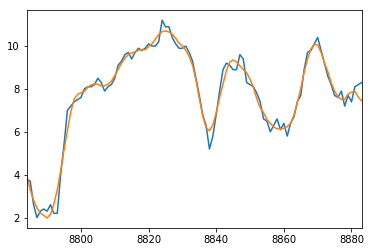

In [58]:
weather_train_df[weather_train_df.site_id==1].air_temperature[:100].plot()
weather_train_df[weather_train_df.site_id==1].air_smooth[:100].plot()

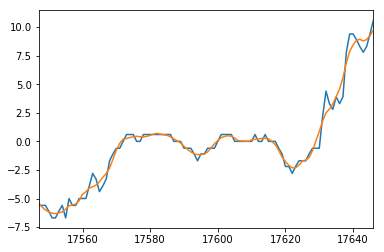

In [59]:
weather_train_df[weather_train_df.site_id==2].dew_temperature[:100].plot()
weather_train_df[weather_train_df.site_id==2].dew_smooth[:100].plot()

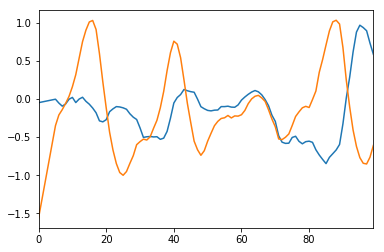

In [60]:
weather_train_df[weather_train_df.site_id==0].dew_diff[:100].plot()
weather_train_df[weather_train_df.site_id==0].air_diff[:100].plot()

# Train model

To win in kaggle competition, how to evaluate your model is important.
What kind of cross validation strategy is suitable for this competition? This is time series data, so it is better to consider time-splitting.

However this notebook is for simple tutorial, so I will proceed with KFold splitting without shuffling, so that at least near-term data is not included in validation.

In [61]:
category_cols = ['building_id', 'site_id', 'primary_use', 'IsHoliday', 'groupNum_train']  # , 'meter'
feature_cols = ['square_feet', 'year_built'] + [
    'hour', 'weekend',
#    'day', # 'month' ,
#    'dayofweek',
#    'building_median'
    ] + [
    'air_temperature', 'cloud_coverage',
    'dew_temperature', 'precip_depth_1_hr',
    'sea_level_pressure',
#'wind_direction', 'wind_speed',
    'air_temperature_mean_lag72',
    'air_temperature_max_lag72', 'air_temperature_min_lag72',
    'air_temperature_std_lag72', 'cloud_coverage_mean_lag72',
    'dew_temperature_mean_lag72', 'precip_depth_1_hr_mean_lag72',
    'sea_level_pressure_mean_lag72',
#'wind_direction_mean_lag72',
    'wind_speed_mean_lag72', 
    'air_temperature_mean_lag3',
    'air_temperature_max_lag3',
    'air_temperature_min_lag3', 'cloud_coverage_mean_lag3',
    'dew_temperature_mean_lag3',
    'precip_depth_1_hr_mean_lag3',
    'sea_level_pressure_mean_lag3',
#    'wind_direction_mean_lag3', 'wind_speed_mean_lag3',
#    'floor_area',
    'year_cnt', 'bid_cnt',
    'dew_smooth', 'air_smooth',
    'dew_diff', 'air_diff',
    'dew_diff2', 'air_diff2'
] + list(df_groupNum_median.drop('timestamp',axis=1).columns)

In [62]:
train_df = train_df.merge(building_meta_df, on=['building_id','meter'], how='left')
train_df = train_df.merge(weather_train_df, on=['site_id', 'timestamp'], how='left')

train_df = reduce_mem_usage(train_df, use_float16=True)

del weather_train_df
gc.collect()

Memory usage of dataframe is 4293.08 MB
Memory usage after optimization is: 3632.61 MB
Decreased by 15.4%


0

In [63]:
def create_X_y(train_df, groupNum_train):
    
    target_train_df = train_df[train_df['groupNum_train'] == groupNum_train].copy()        
    target_train_df = target_train_df.merge(df_groupNum_median, on=['timestamp'], how='left')
    target_train_df['group_median_'+str(groupNum_train)] = np.nan
    
    X_train = target_train_df[feature_cols + category_cols]
    y_train = target_train_df['meter_reading_log1p'].values
    
    del target_train_df
    return X_train, y_train

In [64]:
def fit_lgbm(train, val, devices=(-1,), seed=None, cat_features=None, num_rounds=1500, lr=0.1, bf=0.1):
    """Train Light GBM model"""
    X_train, y_train = train
    X_valid, y_valid = val
    metric = 'l2'
    params = {'num_leaves': 31,
              'objective': 'regression',
#               'max_depth': -1,
              'learning_rate': lr,
              "boosting": "gbdt",
              "bagging_freq": 5,
              "bagging_fraction": bf,
              "feature_fraction": 0.9,
              "metric": metric,
#               "verbosity": -1,
#               'reg_alpha': 0.1,
#               'reg_lambda': 0.3
              }
    device = devices[0]
    if device == -1:
        # use cpu
        pass
    else:
        # use gpu
        print(f'using gpu device_id {device}...')
        params.update({'device': 'gpu', 'gpu_device_id': device})

    params['seed'] = seed

    early_stop = 20
    verbose_eval = 50

    d_train = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_features)
    d_valid = lgb.Dataset(X_valid, label=y_valid, categorical_feature=cat_features)
    watchlist = [d_train, d_valid]

    print('training LGB:')
    model = lgb.train(params,
                      train_set=d_train,
                      num_boost_round=num_rounds,
                      valid_sets=watchlist,
                      verbose_eval=verbose_eval,
                      early_stopping_rounds=early_stop)

    # predictions
    y_pred_valid = model.predict(X_valid, num_iteration=model.best_iteration)
    
    print('best_score', model.best_score)
    log = {'train/mae': model.best_score['training']['l2'],
           'valid/mae': model.best_score['valid_1']['l2']}
    return model, y_pred_valid, log

In [65]:
from sklearn.model_selection import GroupKFold, StratifiedKFold

seed = 666
shuffle = False
#kf = KFold(n_splits=folds, shuffle=shuffle, random_state=seed)
#kf = GroupKFold(n_splits=folds)
kf = StratifiedKFold(n_splits=folds)

# Train model by each group # (site-meter)

In [66]:
def plot_feature_importance(model):
    importance_df = pd.DataFrame(model[1].feature_importance(),
                                 index=feature_cols + category_cols,
                                 columns=['importance']).sort_values('importance')
    fig, ax = plt.subplots(figsize=(8, 8))
    importance_df.plot.barh(ax=ax)
    fig.show()

groupNum_train 0 (559739, 77)
cat_features [72, 73, 74, 75, 76]
[ 5  6  7  8  9 11]
train 373151 valid 186588
training LGB:


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 20 rounds.
[50]	training's l2: 0.0884918	valid_1's l2: 0.191591
[100]	training's l2: 0.0548064	valid_1's l2: 0.164126
[150]	training's l2: 0.0433113	valid_1's l2: 0.155748
[200]	training's l2: 0.0381909	valid_1's l2: 0.153525
Did not meet early stopping. Best iteration is:
[200]	training's l2: 0.0381909	valid_1's l2: 0.153525
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.038190944774657565}, 'valid_1': {'l2': 0.15352518149941421}})
[ 8  9 10 11 12]
train 373154 valid 186585
training LGB:
Training until validation scores don't improve for 20 rounds.
[50]	training's l2: 0.12238	valid_1's l2: 0.098867
Early stopping, best iteration is:
[63]	training's l2: 0.103178	valid_1's l2: 0.0953059
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.10317792920353472}, 'valid_1': {'l2': 0.0953058541450894}})
[10 11 12]
train 373173 valid 186566
training LGB:
Training until validation scores don't improve for 20 rounds.
[50]	t

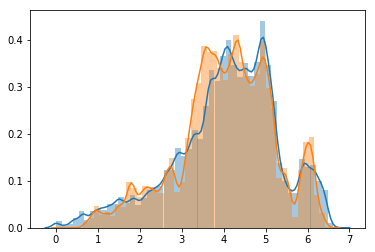

-------------------------------------------------------------
groupNum_train 1 (164279, 77)
cat_features [72, 73, 74, 75, 76]
[2 3 4 5 6 7 8]
train 109515 valid 54764
training LGB:


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 20 rounds.
[50]	training's l2: 1.17013	valid_1's l2: 2.58408
Early stopping, best iteration is:
[49]	training's l2: 1.18329	valid_1's l2: 2.57931
best_score defaultdict(<class 'dict'>, {'training': {'l2': 1.183289887827201}, 'valid_1': {'l2': 2.5793091108647346}})
[ 5  6  7  8  9 10]
train 109518 valid 54761
training LGB:
Training until validation scores don't improve for 20 rounds.
[50]	training's l2: 1.37678	valid_1's l2: 2.00845
[100]	training's l2: 0.956251	valid_1's l2: 1.89212
[150]	training's l2: 0.814267	valid_1's l2: 1.868
Early stopping, best iteration is:
[173]	training's l2: 0.772193	valid_1's l2: 1.85128
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.7721928916380798}, 'valid_1': {'l2': 1.8512818406501652}})
[ 7  8  9 10 11 12]
train 109525 valid 54754
training LGB:
Training until validation scores don't improve for 20 rounds.
[50]	training's l2: 1.10078	valid_1's l2: 2.79055
[100]	training's l2: 0.779492	val

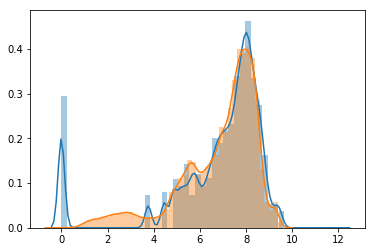

-------------------------------------------------------------
groupNum_train 10 (447982, 77)
cat_features [72, 73, 74, 75, 76]
[1 2 3 4 5]
train 298654 valid 149328
training LGB:


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 20 rounds.
[50]	training's l2: 0.105347	valid_1's l2: 0.409539
Early stopping, best iteration is:
[42]	training's l2: 0.131177	valid_1's l2: 0.392313
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.1311773501783618}, 'valid_1': {'l2': 0.39231286982440805}})
[5 6 7 8 9]
train 298655 valid 149327
training LGB:
Training until validation scores don't improve for 20 rounds.
[50]	training's l2: 0.0842711	valid_1's l2: 0.279582
[100]	training's l2: 0.0416431	valid_1's l2: 0.24752
[150]	training's l2: 0.0293826	valid_1's l2: 0.2424
Early stopping, best iteration is:
[168]	training's l2: 0.027287	valid_1's l2: 0.241287
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.02728701005361699}, 'valid_1': {'l2': 0.24128666480143465}})
[ 9 10 11 12]
train 298655 valid 149327
training LGB:
Training until validation scores don't improve for 20 rounds.
[50]	training's l2: 0.062387	valid_1's l2: 0.508041
Early stopping, best iterati

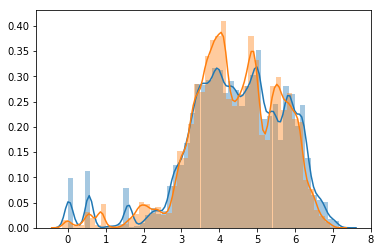

-------------------------------------------------------------
groupNum_train 13 (91387, 77)
cat_features [72, 73, 74, 75, 76]
[1 2 3 4 5]
train 60920 valid 30467
training LGB:


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 20 rounds.
[50]	training's l2: 1.89836	valid_1's l2: 1.77774
[100]	training's l2: 1.64361	valid_1's l2: 1.61964
Early stopping, best iteration is:
[125]	training's l2: 1.58816	valid_1's l2: 1.58971
best_score defaultdict(<class 'dict'>, {'training': {'l2': 1.5881614256068861}, 'valid_1': {'l2': 1.5897113872042679}})
[3 4 5 6 7 8 9]
train 60924 valid 30463
training LGB:
Training until validation scores don't improve for 20 rounds.
[50]	training's l2: 1.43803	valid_1's l2: 2.96212
Early stopping, best iteration is:
[37]	training's l2: 1.58383	valid_1's l2: 2.92668
best_score defaultdict(<class 'dict'>, {'training': {'l2': 1.5838333318769588}, 'valid_1': {'l2': 2.926683182855062}})
[ 6  7  8  9 10 11 12]
train 60930 valid 30457
training LGB:
Training until validation scores don't improve for 20 rounds.
[50]	training's l2: 1.55567	valid_1's l2: 3.39301
[100]	training's l2: 1.41881	valid_1's l2: 3.36916
Early stopping, best iteration is:
[1

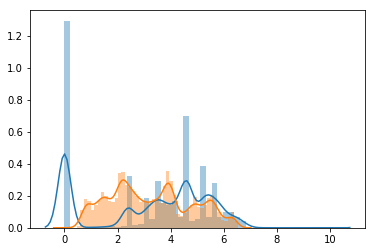

-------------------------------------------------------------
groupNum_train 20 (1181075, 77)
cat_features [72, 73, 74, 75, 76]
[1 2 3 4 5]
train 787341 valid 393734
training LGB:


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 20 rounds.
[50]	training's l2: 0.162323	valid_1's l2: 0.20866
[100]	training's l2: 0.108204	valid_1's l2: 0.179538
[150]	training's l2: 0.0851923	valid_1's l2: 0.163408
[200]	training's l2: 0.0735486	valid_1's l2: 0.152206
Did not meet early stopping. Best iteration is:
[200]	training's l2: 0.0735486	valid_1's l2: 0.152206
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.07354862013987794}, 'valid_1': {'l2': 0.1522059744330453}})
[4 5 6 7 8 9]
train 787378 valid 393697
training LGB:
Training until validation scores don't improve for 20 rounds.
[50]	training's l2: 0.141363	valid_1's l2: 0.206321
[100]	training's l2: 0.0950484	valid_1's l2: 0.180069
[150]	training's l2: 0.0732234	valid_1's l2: 0.177142
Early stopping, best iteration is:
[146]	training's l2: 0.0743683	valid_1's l2: 0.176161
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.07436827306236331}, 'valid_1': {'l2': 0.17616126240690502}})
[ 7  8  9 10 11 

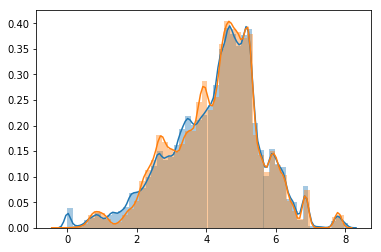

-------------------------------------------------------------
groupNum_train 21 (844854, 77)
cat_features [72, 73, 74, 75, 76]
[1 2 3 4 5 6 7]
train 563206 valid 281648
training LGB:


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 20 rounds.
[50]	training's l2: 0.751902	valid_1's l2: 1.28337
[100]	training's l2: 0.583339	valid_1's l2: 1.23754
Early stopping, best iteration is:
[119]	training's l2: 0.54956	valid_1's l2: 1.2342
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.5495600542386104}, 'valid_1': {'l2': 1.2341961083532509}})
[ 3  4  5  6  7  8  9 10]
train 563233 valid 281621
training LGB:
Training until validation scores don't improve for 20 rounds.
[50]	training's l2: 0.869278	valid_1's l2: 1.00397
[100]	training's l2: 0.668855	valid_1's l2: 0.883776
Early stopping, best iteration is:
[96]	training's l2: 0.678614	valid_1's l2: 0.883546
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.6786144217539831}, 'valid_1': {'l2': 0.8835457328757712}})
[ 7  8  9 10 11 12]
train 563269 valid 281585
training LGB:
Training until validation scores don't improve for 20 rounds.
[50]	training's l2: 0.722277	valid_1's l2: 1.22783
[100]	training's l

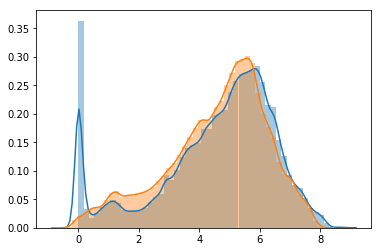

-------------------------------------------------------------
groupNum_train 23 (386956, 77)
cat_features [72, 73, 74, 75, 76]
[1 2 3 4 5 6]
train 257952 valid 129004
training LGB:


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 20 rounds.
[50]	training's l2: 0.570375	valid_1's l2: 1.0949
Early stopping, best iteration is:
[71]	training's l2: 0.499554	valid_1's l2: 1.01105
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.49955361307160145}, 'valid_1': {'l2': 1.0110525463020599}})
[ 1  2  3  4  5  6  7  8  9 10]
train 257972 valid 128984
training LGB:
Training until validation scores don't improve for 20 rounds.
[50]	training's l2: 0.596791	valid_1's l2: 0.921124
Early stopping, best iteration is:
[75]	training's l2: 0.517828	valid_1's l2: 0.905852
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.5178279702496148}, 'valid_1': {'l2': 0.9058516795085576}})
[ 1  2  3  4  5  6  7  8  9 10 11 12]
train 257988 valid 128968
training LGB:
Training until validation scores don't improve for 20 rounds.
[50]	training's l2: 0.450366	valid_1's l2: 1.22972
[100]	training's l2: 0.355264	valid_1's l2: 1.21801
Early stopping, best iteration is:
[99]	train

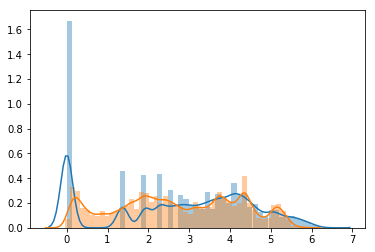

-------------------------------------------------------------
groupNum_train 30 (2370097, 77)
cat_features [72, 73, 74, 75, 76]
[ 1  2  3  4  5  6  7  8 12]
train 1579898 valid 790199
training LGB:


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 20 rounds.
[50]	training's l2: 0.14194	valid_1's l2: 0.235776
[100]	training's l2: 0.0969514	valid_1's l2: 0.206797
[150]	training's l2: 0.08172	valid_1's l2: 0.199329
Early stopping, best iteration is:
[158]	training's l2: 0.0797587	valid_1's l2: 0.19866
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.07975873390337455}, 'valid_1': {'l2': 0.19865997025806564}})
[ 2  3  4  5  6  7  8  9 10 12]
train 1580142 valid 789955
training LGB:
Training until validation scores don't improve for 20 rounds.
[50]	training's l2: 0.155157	valid_1's l2: 0.218528
[100]	training's l2: 0.0996934	valid_1's l2: 0.156735
[150]	training's l2: 0.0798796	valid_1's l2: 0.154169
Early stopping, best iteration is:
[164]	training's l2: 0.0769255	valid_1's l2: 0.153126
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.07692550598876426}, 'valid_1': {'l2': 0.1531263845916293}})
[ 3  4  6  7  8  9 10 11 12]
train 1580154 valid 789943
training L

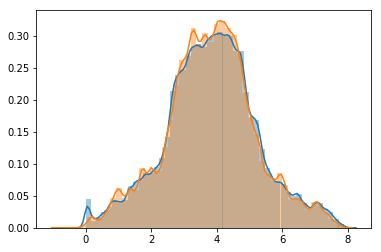

-------------------------------------------------------------
groupNum_train 40 (746700, 77)
cat_features [72, 73, 74, 75, 76]
[ 1  2  3  4  5  6  7  8  9 10 11 12]
train 497770 valid 248930
training LGB:


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 20 rounds.
[50]	training's l2: 0.0660024	valid_1's l2: 0.0704546
[100]	training's l2: 0.0360228	valid_1's l2: 0.0490667
[150]	training's l2: 0.0296791	valid_1's l2: 0.045485
[200]	training's l2: 0.0264497	valid_1's l2: 0.0438139
Did not meet early stopping. Best iteration is:
[200]	training's l2: 0.0264497	valid_1's l2: 0.0438139
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.02644969797349216}, 'valid_1': {'l2': 0.04381389948448154}})
[ 3  4  5  6  7  8  9 10 11 12]
train 497787 valid 248913
training LGB:
Training until validation scores don't improve for 20 rounds.
[50]	training's l2: 0.0646882	valid_1's l2: 0.0802734
[100]	training's l2: 0.0353343	valid_1's l2: 0.0517628
[150]	training's l2: 0.0293045	valid_1's l2: 0.0487988
[200]	training's l2: 0.0259333	valid_1's l2: 0.0475291
Did not meet early stopping. Best iteration is:
[200]	training's l2: 0.0259333	valid_1's l2: 0.0475291
best_score defaultdict(<class 'dict'>, 

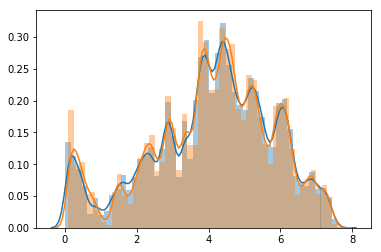

-------------------------------------------------------------
groupNum_train 50 (778919, 77)
cat_features [72, 73, 74, 75, 76]
[1 2 3 4 5 6 7]
train 519279 valid 259640
training LGB:


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 20 rounds.
[50]	training's l2: 0.330782	valid_1's l2: 0.422871
[100]	training's l2: 0.243382	valid_1's l2: 0.393268
[150]	training's l2: 0.201855	valid_1's l2: 0.381607
[200]	training's l2: 0.178272	valid_1's l2: 0.376229
Did not meet early stopping. Best iteration is:
[200]	training's l2: 0.178272	valid_1's l2: 0.376229
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.17827190312311908}, 'valid_1': {'l2': 0.37622901748280496}})
[ 4  5  6  7  8  9 10]
train 519279 valid 259640
training LGB:
Training until validation scores don't improve for 20 rounds.
[50]	training's l2: 0.325848	valid_1's l2: 0.429394
[100]	training's l2: 0.246168	valid_1's l2: 0.407874
[150]	training's l2: 0.206403	valid_1's l2: 0.401968
[200]	training's l2: 0.183256	valid_1's l2: 0.398127
Did not meet early stopping. Best iteration is:
[200]	training's l2: 0.183256	valid_1's l2: 0.398127
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.183255

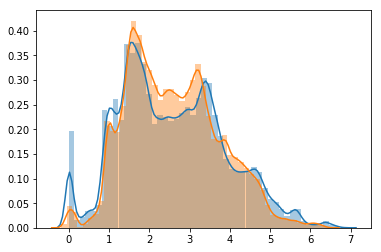

-------------------------------------------------------------
groupNum_train 60 (315436, 77)
cat_features [72, 73, 74, 75, 76]
[1 2 3 4 5]
train 210283 valid 105153
training LGB:


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 20 rounds.
[50]	training's l2: 0.0426966	valid_1's l2: 0.0625883
[100]	training's l2: 0.0249436	valid_1's l2: 0.0401723
[150]	training's l2: 0.0198034	valid_1's l2: 0.0368511
[200]	training's l2: 0.0173395	valid_1's l2: 0.0353821
Did not meet early stopping. Best iteration is:
[200]	training's l2: 0.0173395	valid_1's l2: 0.0353821
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.017339527089897167}, 'valid_1': {'l2': 0.03538209461587418}})
[5 6 7 8 9]
train 210292 valid 105144
training LGB:
Training until validation scores don't improve for 20 rounds.
[50]	training's l2: 0.0345594	valid_1's l2: 0.127734
[100]	training's l2: 0.0187152	valid_1's l2: 0.103857
Early stopping, best iteration is:
[120]	training's l2: 0.0170279	valid_1's l2: 0.102365
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.01702790870298545}, 'valid_1': {'l2': 0.10236451490146625}})
[ 8  9 10 11 12]
train 210297 valid 105139
training LGB:
Trai

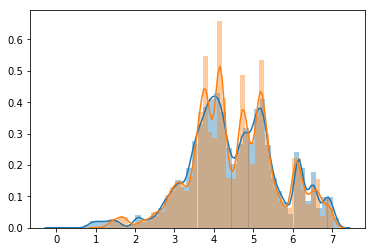

-------------------------------------------------------------
groupNum_train 62 (163168, 77)
cat_features [72, 73, 74, 75, 76]
[ 1  2  3  4  5  9 10]
train 108770 valid 54398
training LGB:


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 20 rounds.
[50]	training's l2: 1.47073	valid_1's l2: 2.15979
[100]	training's l2: 1.14393	valid_1's l2: 2.03158
[150]	training's l2: 1.02985	valid_1's l2: 2.01768
Early stopping, best iteration is:
[172]	training's l2: 0.995149	valid_1's l2: 2.00821
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.9951488503092354}, 'valid_1': {'l2': 2.0082104470199638}})
[ 2  3  4  5  6  7  8  9 10 12]
train 108778 valid 54390
training LGB:
Training until validation scores don't improve for 20 rounds.
[50]	training's l2: 1.41525	valid_1's l2: 2.2071
[100]	training's l2: 1.0413	valid_1's l2: 1.89436
[150]	training's l2: 0.909681	valid_1's l2: 1.82442
[200]	training's l2: 0.826816	valid_1's l2: 1.78378
Did not meet early stopping. Best iteration is:
[200]	training's l2: 0.826816	valid_1's l2: 1.78378
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.8268162461816995}, 'valid_1': {'l2': 1.7837811597682887}})
[ 4  5  7  8  9 10 11 1

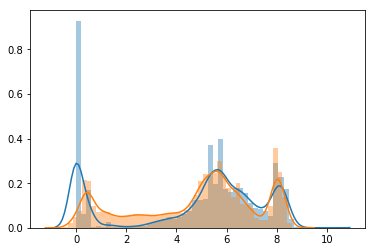

-------------------------------------------------------------
groupNum_train 61 (147831, 77)
cat_features [72, 73, 74, 75, 76]
[1 2 3 4 5 6]
train 98546 valid 49285
training LGB:


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 20 rounds.
[50]	training's l2: 0.965894	valid_1's l2: 2.386
Early stopping, best iteration is:
[65]	training's l2: 0.817854	valid_1's l2: 2.32771
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.8178544119727194}, 'valid_1': {'l2': 2.327713728126874}})
[4 5 6 7 8 9]
train 98554 valid 49277
training LGB:
Training until validation scores don't improve for 20 rounds.
[50]	training's l2: 1.06266	valid_1's l2: 1.88323
[100]	training's l2: 0.729241	valid_1's l2: 1.59684
[150]	training's l2: 0.612643	valid_1's l2: 1.53195
Early stopping, best iteration is:
[177]	training's l2: 0.571205	valid_1's l2: 1.52009
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.5712047652400579}, 'valid_1': {'l2': 1.5200926190651287}})
[ 6  7  8  9 10 11 12]
train 98562 valid 49269
training LGB:
Training until validation scores don't improve for 20 rounds.
[50]	training's l2: 0.798553	valid_1's l2: 3.45926
Early stopping, best iteration is:


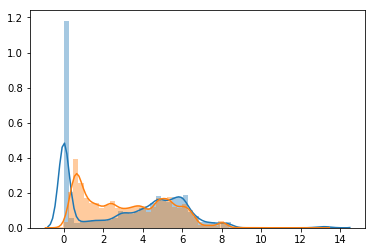

-------------------------------------------------------------
groupNum_train 71 (105217, 77)
cat_features [72, 73, 74, 75, 76]
[1 2 3 4 5 6 7]
train 70141 valid 35076
training LGB:


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 20 rounds.
[50]	training's l2: 0.763464	valid_1's l2: 2.42845
[100]	training's l2: 0.542006	valid_1's l2: 2.3777
Early stopping, best iteration is:
[103]	training's l2: 0.534411	valid_1's l2: 2.37399
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.5344108847481323}, 'valid_1': {'l2': 2.3739855526929685}})
[4 5 6 7 8 9]
train 70145 valid 35072
training LGB:
Training until validation scores don't improve for 20 rounds.
[50]	training's l2: 0.979312	valid_1's l2: 1.35385
[100]	training's l2: 0.673515	valid_1's l2: 1.12788
[150]	training's l2: 0.557914	valid_1's l2: 1.08052
[200]	training's l2: 0.485932	valid_1's l2: 1.07102
Did not meet early stopping. Best iteration is:
[200]	training's l2: 0.485932	valid_1's l2: 1.07102
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.48593185064859656}, 'valid_1': {'l2': 1.0710207125399205}})
[ 8  9 10 11 12]
train 70148 valid 35069
training LGB:
Training until validation scores

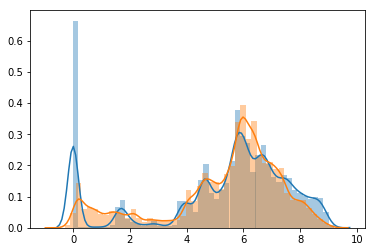

-------------------------------------------------------------
groupNum_train 72 (88558, 77)
cat_features [72, 73, 74, 75, 76]
[1 2 3 4 5]
train 59035 valid 29523
training LGB:


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 20 rounds.
[50]	training's l2: 1.2819	valid_1's l2: 1.6867
[100]	training's l2: 0.941543	valid_1's l2: 1.44418
[150]	training's l2: 0.823244	valid_1's l2: 1.36315
Early stopping, best iteration is:
[152]	training's l2: 0.818733	valid_1's l2: 1.35793
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.8187327895617673}, 'valid_1': {'l2': 1.3579255615328614}})
[ 3  4  5  6  7  8  9 10]
train 59040 valid 29518
training LGB:
Training until validation scores don't improve for 20 rounds.
[50]	training's l2: 0.739927	valid_1's l2: 2.79561
[100]	training's l2: 0.50846	valid_1's l2: 2.45558
[150]	training's l2: 0.418411	valid_1's l2: 2.43599
Early stopping, best iteration is:
[156]	training's l2: 0.410343	valid_1's l2: 2.42575
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.41034330950866527}, 'valid_1': {'l2': 2.42574762601423}})
[ 5  6  7  8  9 10 11 12]
train 59041 valid 29517
training LGB:
Training until validation sco

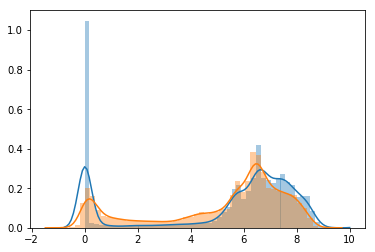

-------------------------------------------------------------
groupNum_train 70 (93979, 77)
cat_features [72, 73, 74, 75, 76]
[1 2 3 4 5 6 7 8 9]
train 62650 valid 31329
training LGB:


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 20 rounds.
Early stopping, best iteration is:
[29]	training's l2: 0.221275	valid_1's l2: 2.87544
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.22127508703527912}, 'valid_1': {'l2': 2.8754416754667753}})
[ 3  4  5  6  7  8  9 10 11]
train 62653 valid 31326
training LGB:
Training until validation scores don't improve for 20 rounds.
[50]	training's l2: 0.0943561	valid_1's l2: 0.884256
Early stopping, best iteration is:
[34]	training's l2: 0.190622	valid_1's l2: 0.863856
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.19062150163084182}, 'valid_1': {'l2': 0.8638560233719519}})
[ 6  7  8  9 10 11 12]
train 62655 valid 31324
training LGB:
Training until validation scores don't improve for 20 rounds.
Early stopping, best iteration is:
[3]	training's l2: 2.01017	valid_1's l2: 1.6454
best_score defaultdict(<class 'dict'>, {'training': {'l2': 2.0101702245447317}, 'valid_1': {'l2': 1.6453957594966864}})


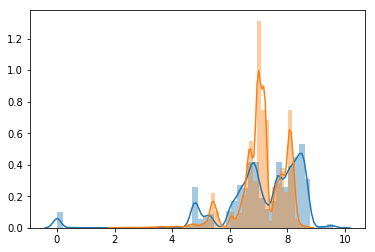

-------------------------------------------------------------
groupNum_train 73 (26137, 77)
cat_features [72, 73, 74, 75, 76]
[1 2 3 4 5]
train 17423 valid 8714
training LGB:


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 20 rounds.
[50]	training's l2: 2.34049	valid_1's l2: 1.74175
[100]	training's l2: 1.77411	valid_1's l2: 1.68223
Early stopping, best iteration is:
[80]	training's l2: 1.92233	valid_1's l2: 1.64167
best_score defaultdict(<class 'dict'>, {'training': {'l2': 1.922326408891611}, 'valid_1': {'l2': 1.641673440791843}})
[4 5 6 7 8 9]
train 17425 valid 8712
training LGB:
Training until validation scores don't improve for 20 rounds.
[50]	training's l2: 0.896665	valid_1's l2: 6.31251
Early stopping, best iteration is:
[60]	training's l2: 0.808385	valid_1's l2: 6.2453
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.8083852061632609}, 'valid_1': {'l2': 6.245295946481126}})
[ 8  9 10 11 12]
train 17426 valid 8711
training LGB:
Training until validation scores don't improve for 20 rounds.
[50]	training's l2: 1.62234	valid_1's l2: 4.3453
Early stopping, best iteration is:
[45]	training's l2: 1.71809	valid_1's l2: 4.30371
best_score defau

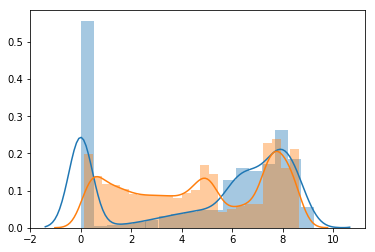

-------------------------------------------------------------
groupNum_train 80 (556808, 77)
cat_features [72, 73, 74, 75, 76]
[1 2 3 4 5 6]
train 371184 valid 185624
training LGB:


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 20 rounds.
[50]	training's l2: 0.22119	valid_1's l2: 0.294889
[100]	training's l2: 0.169506	valid_1's l2: 0.273686
Early stopping, best iteration is:
[102]	training's l2: 0.168292	valid_1's l2: 0.273605
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.16829249350115083}, 'valid_1': {'l2': 0.273605451946708}})
[2 3 4 5 6 7 8 9]
train 371187 valid 185621
training LGB:
Training until validation scores don't improve for 20 rounds.
[50]	training's l2: 0.204282	valid_1's l2: 0.324472
[100]	training's l2: 0.156952	valid_1's l2: 0.312405
Early stopping, best iteration is:
[88]	training's l2: 0.163482	valid_1's l2: 0.31197
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.16348197488975588}, 'valid_1': {'l2': 0.311970236246281}})
[ 3  4  5  8  9 10 11 12]
train 371245 valid 185563
training LGB:
Training until validation scores don't improve for 20 rounds.
[50]	training's l2: 0.230738	valid_1's l2: 0.270004
[100]	training'

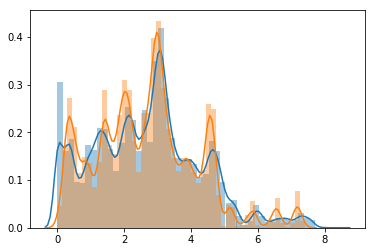

-------------------------------------------------------------
groupNum_train 90 (1053128, 77)
cat_features [72, 73, 74, 75, 76]
[1 2 3 4 5 6 7 8 9]
train 702046 valid 351082
training LGB:


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 20 rounds.
[50]	training's l2: 0.0864561	valid_1's l2: 0.345891
Early stopping, best iteration is:
[60]	training's l2: 0.0716906	valid_1's l2: 0.33916
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.07169055155911379}, 'valid_1': {'l2': 0.33915999808363156}})
[ 3  4  5  6  7  8  9 10 11]
train 702086 valid 351042
training LGB:
Training until validation scores don't improve for 20 rounds.
[50]	training's l2: 0.143244	valid_1's l2: 0.13113
[100]	training's l2: 0.0744998	valid_1's l2: 0.108631
Early stopping, best iteration is:
[100]	training's l2: 0.0744998	valid_1's l2: 0.108631
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.07449977329838477}, 'valid_1': {'l2': 0.10863134097418486}})
[ 6  8  9 10 11 12]
train 702124 valid 351004
training LGB:
Training until validation scores don't improve for 20 rounds.
[50]	training's l2: 0.139153	valid_1's l2: 0.220026
Early stopping, best iteration is:
[38]	training's l2: 

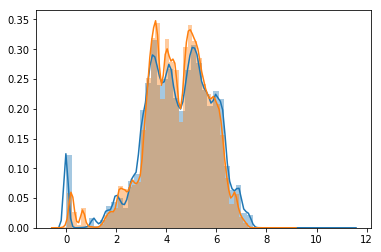

-------------------------------------------------------------
groupNum_train 91 (823947, 77)
cat_features [72, 73, 74, 75, 76]
[1 2 3 4 5 6 8 9]
train 549264 valid 274683
training LGB:


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 20 rounds.
[50]	training's l2: 0.282976	valid_1's l2: 0.694083
[100]	training's l2: 0.184523	valid_1's l2: 0.641448
Early stopping, best iteration is:
[115]	training's l2: 0.169258	valid_1's l2: 0.636212
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.16925829927631453}, 'valid_1': {'l2': 0.6362122874603795}})
[ 4  5  6  7  8  9 10 11]
train 549296 valid 274651
training LGB:
Training until validation scores don't improve for 20 rounds.
[50]	training's l2: 0.430351	valid_1's l2: 0.452752
Early stopping, best iteration is:
[59]	training's l2: 0.389131	valid_1's l2: 0.446171
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.3891309984239197}, 'valid_1': {'l2': 0.4461708831341917}})
[ 7  8  9 10 11 12]
train 549334 valid 274613
training LGB:
Training until validation scores don't improve for 20 rounds.
[50]	training's l2: 0.295461	valid_1's l2: 0.599347
[100]	training's l2: 0.203902	valid_1's l2: 0.581347
Early stop

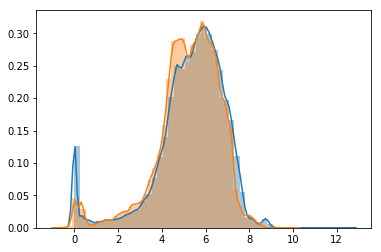

-------------------------------------------------------------
groupNum_train 92 (764056, 77)
cat_features [72, 73, 74, 75, 76]
[1 2 3 4 5 6 7 8 9]
train 509345 valid 254711
training LGB:


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 20 rounds.
[50]	training's l2: 0.99701	valid_1's l2: 1.19711
[100]	training's l2: 0.902738	valid_1's l2: 1.14803
[150]	training's l2: 0.865038	valid_1's l2: 1.14019
Early stopping, best iteration is:
[144]	training's l2: 0.869676	valid_1's l2: 1.13762
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.8696759734485144}, 'valid_1': {'l2': 1.1376204960264489}})
[ 4  5  6  7  8  9 10 11]
train 509367 valid 254689
training LGB:
Training until validation scores don't improve for 20 rounds.
[50]	training's l2: 0.913493	valid_1's l2: 1.28478
[100]	training's l2: 0.787623	valid_1's l2: 1.21887
[150]	training's l2: 0.730925	valid_1's l2: 1.2034
[200]	training's l2: 0.693843	valid_1's l2: 1.19555
Did not meet early stopping. Best iteration is:
[200]	training's l2: 0.693843	valid_1's l2: 1.19555
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.6938433421367851}, 'valid_1': {'l2': 1.1955542459655992}})
[ 9 10 11 12]
train 509

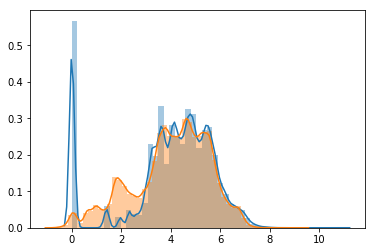

-------------------------------------------------------------
groupNum_train 100 (236573, 77)
cat_features [72, 73, 74, 75, 76]
[1 2 3 4 5 7]
train 157705 valid 78868
training LGB:


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 20 rounds.
[50]	training's l2: 0.145163	valid_1's l2: 0.184602
[100]	training's l2: 0.106977	valid_1's l2: 0.158309
[150]	training's l2: 0.093433	valid_1's l2: 0.154954
Early stopping, best iteration is:
[162]	training's l2: 0.0909883	valid_1's l2: 0.154274
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.09098828261188543}, 'valid_1': {'l2': 0.154273523603159}})
[ 2  3  4  5  6  7  8  9 10]
train 157716 valid 78857
training LGB:
Training until validation scores don't improve for 20 rounds.
[50]	training's l2: 0.126027	valid_1's l2: 0.19851
[100]	training's l2: 0.0907147	valid_1's l2: 0.189373
Early stopping, best iteration is:
[98]	training's l2: 0.091614	valid_1's l2: 0.188784
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.09161402450208089}, 'valid_1': {'l2': 0.18878369664903075}})
[ 3  4  5  6  7  8  9 10 11 12]
train 157725 valid 78848
training LGB:
Training until validation scores don't improve for 20 ro

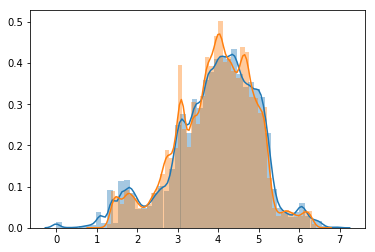

-------------------------------------------------------------
groupNum_train 101 (51636, 77)
cat_features [72, 73, 74, 75, 76]
[1 2 3 4 5 6]
train 34421 valid 17215
training LGB:


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 20 rounds.
Early stopping, best iteration is:
[23]	training's l2: 1.86444	valid_1's l2: 4.21374
best_score defaultdict(<class 'dict'>, {'training': {'l2': 1.8644385401990313}, 'valid_1': {'l2': 4.213737512798631}})
[ 1  3  5  6  7  8  9 11]
train 34423 valid 17213
training LGB:
Training until validation scores don't improve for 20 rounds.
[50]	training's l2: 1.33949	valid_1's l2: 1.92392
[100]	training's l2: 1.07585	valid_1's l2: 1.81678
Early stopping, best iteration is:
[115]	training's l2: 1.03989	valid_1's l2: 1.79937
best_score defaultdict(<class 'dict'>, {'training': {'l2': 1.0398904612633149}, 'valid_1': {'l2': 1.7993739533916346}})
[ 3  4  5  8  9 10 11 12]
train 34428 valid 17208
training LGB:
Training until validation scores don't improve for 20 rounds.
Early stopping, best iteration is:
[29]	training's l2: 1.54467	valid_1's l2: 4.01856
best_score defaultdict(<class 'dict'>, {'training': {'l2': 1.5446662308032864}, 'valid_1':

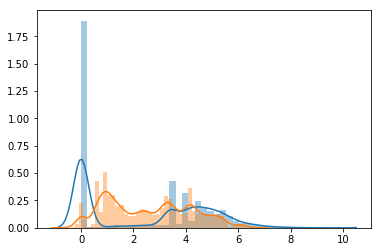

-------------------------------------------------------------
groupNum_train 103 (83138, 77)
cat_features [72, 73, 74, 75, 76]
[1 2 3 4 5]
train 55421 valid 27717
training LGB:


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 20 rounds.
[50]	training's l2: 2.17606	valid_1's l2: 4.63784
Early stopping, best iteration is:
[60]	training's l2: 2.03159	valid_1's l2: 4.60561
best_score defaultdict(<class 'dict'>, {'training': {'l2': 2.031593689184017}, 'valid_1': {'l2': 4.6056077391519095}})
[ 3  4  5  6  7  8  9 10]
train 55426 valid 27712
training LGB:
Training until validation scores don't improve for 20 rounds.
[50]	training's l2: 2.5084	valid_1's l2: 5.24373
[100]	training's l2: 2.0056	valid_1's l2: 4.73347
[150]	training's l2: 1.7784	valid_1's l2: 4.63749
[200]	training's l2: 1.63704	valid_1's l2: 4.53463
Did not meet early stopping. Best iteration is:
[200]	training's l2: 1.63704	valid_1's l2: 4.53463
best_score defaultdict(<class 'dict'>, {'training': {'l2': 1.6370413751420068}, 'valid_1': {'l2': 4.534627307019574}})
[ 8  9 10 11 12]
train 55429 valid 27709
training LGB:
Training until validation scores don't improve for 20 rounds.
[50]	training's l2: 2.1

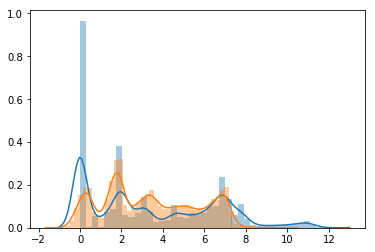

-------------------------------------------------------------
groupNum_train 110 (43400, 77)
cat_features [72, 73, 74, 75, 76]
[1 2 3 4 5]
train 28931 valid 14469
training LGB:


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 20 rounds.
[50]	training's l2: 0.0143429	valid_1's l2: 0.0189395
[100]	training's l2: 0.00778571	valid_1's l2: 0.0124425
[150]	training's l2: 0.00625437	valid_1's l2: 0.0115718
Early stopping, best iteration is:
[151]	training's l2: 0.00623875	valid_1's l2: 0.0115539
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.006238745286911666}, 'valid_1': {'l2': 0.011553898570176952}})
[4 5 6 7 8 9]
train 28934 valid 14466
training LGB:
Training until validation scores don't improve for 20 rounds.
[50]	training's l2: 0.00984756	valid_1's l2: 0.0394044
[100]	training's l2: 0.0045482	valid_1's l2: 0.0342923
[150]	training's l2: 0.00352561	valid_1's l2: 0.0350741
Early stopping, best iteration is:
[130]	training's l2: 0.00382874	valid_1's l2: 0.0338856
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.003828737911619875}, 'valid_1': {'l2': 0.033885619019157265}})
[ 9 10 11 12]
train 28935 valid 14465
training LGB:
Training u

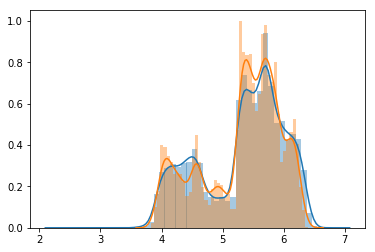

-------------------------------------------------------------
groupNum_train 111 (13954, 77)
cat_features [72, 73, 74, 75, 76]
[1 5 6 7]
train 9301 valid 4653
training LGB:
Training until validation scores don't improve for 20 rounds.


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[50]	training's l2: 0.455851	valid_1's l2: 3.16297
Early stopping, best iteration is:
[50]	training's l2: 0.455851	valid_1's l2: 3.16297
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.4558507150756773}, 'valid_1': {'l2': 3.162971694263097}})
[6 7 8]
train 9302 valid 4652
training LGB:
Training until validation scores don't improve for 20 rounds.
[50]	training's l2: 0.631578	valid_1's l2: 1.19174
Early stopping, best iteration is:
[67]	training's l2: 0.49534	valid_1's l2: 1.14485
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.49533986823810705}, 'valid_1': {'l2': 1.1448537890072035}})
[ 8  9 10 11]
train 9305 valid 4649
training LGB:
Training until validation scores don't improve for 20 rounds.
[50]	training's l2: 0.634536	valid_1's l2: 2.67375
Early stopping, best iteration is:
[79]	training's l2: 0.483106	valid_1's l2: 2.62845
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.4831058122237224}, 'valid_1': {'l2': 2.628446161830555}})


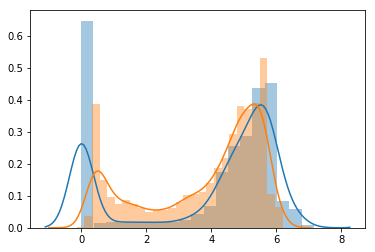

-------------------------------------------------------------
groupNum_train 113 (43403, 77)
cat_features [72, 73, 74, 75, 76]
[1 2 3 4 5]
train 28934 valid 14469
training LGB:


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 20 rounds.
[50]	training's l2: 0.380028	valid_1's l2: 0.412556
[100]	training's l2: 0.26831	valid_1's l2: 0.313945
[150]	training's l2: 0.226155	valid_1's l2: 0.307486
Early stopping, best iteration is:
[138]	training's l2: 0.233195	valid_1's l2: 0.304404
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.23319529841215647}, 'valid_1': {'l2': 0.30440404748110295}})
[4 5 6 7 8 9]
train 28935 valid 14468
training LGB:
Training until validation scores don't improve for 20 rounds.
[50]	training's l2: 0.295956	valid_1's l2: 0.817098
[100]	training's l2: 0.204546	valid_1's l2: 0.688353
Early stopping, best iteration is:
[126]	training's l2: 0.185097	valid_1's l2: 0.681474
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.18509734058493907}, 'valid_1': {'l2': 0.6814738440936295}})
[ 9 10 11 12]
train 28937 valid 14466
training LGB:
Training until validation scores don't improve for 20 rounds.
[50]	training's l2: 0.252624	

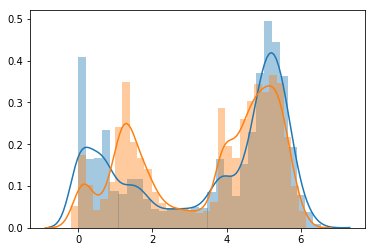

-------------------------------------------------------------
groupNum_train 120 (315772, 77)
cat_features [72, 73, 74, 75, 76]
[1 2 3 4 5]
train 210507 valid 105265
training LGB:


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 20 rounds.
[50]	training's l2: 0.151427	valid_1's l2: 0.22503
[100]	training's l2: 0.107532	valid_1's l2: 0.217362
Early stopping, best iteration is:
[82]	training's l2: 0.120011	valid_1's l2: 0.216812
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.12001147028076316}, 'valid_1': {'l2': 0.21681157852176106}})
[5 6 7 8 9]
train 210512 valid 105260
training LGB:
Training until validation scores don't improve for 20 rounds.
[50]	training's l2: 0.164377	valid_1's l2: 0.203185
[100]	training's l2: 0.119253	valid_1's l2: 0.188561
[150]	training's l2: 0.0960185	valid_1's l2: 0.186276
[200]	training's l2: 0.0833119	valid_1's l2: 0.186609
Did not meet early stopping. Best iteration is:
[200]	training's l2: 0.0833119	valid_1's l2: 0.186609
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.08331186085112627}, 'valid_1': {'l2': 0.18660881256221917}})
[ 8  9 10 11 12]
train 210525 valid 105247
training LGB:
Training until va

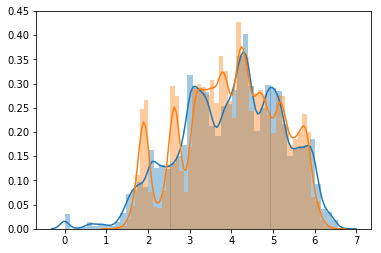

-------------------------------------------------------------
groupNum_train 130 (1210541, 77)
cat_features [72, 73, 74, 75, 76]
[ 1  2  3  4  5  7  8  9 11]
train 807008 valid 403533
training LGB:


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 20 rounds.
[50]	training's l2: 0.140454	valid_1's l2: 0.164847
[100]	training's l2: 0.0864032	valid_1's l2: 0.124103
[150]	training's l2: 0.0678964	valid_1's l2: 0.113471
[200]	training's l2: 0.0575515	valid_1's l2: 0.108809
Did not meet early stopping. Best iteration is:
[200]	training's l2: 0.0575515	valid_1's l2: 0.108809
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.05755153285714235}, 'valid_1': {'l2': 0.10880946944109247}})
[ 4  5  6  7  8  9 10 11 12]
train 807018 valid 403523
training LGB:
Training until validation scores don't improve for 20 rounds.
[50]	training's l2: 0.103778	valid_1's l2: 0.283622
[100]	training's l2: 0.0568845	valid_1's l2: 0.221395
[150]	training's l2: 0.042559	valid_1's l2: 0.196795
[200]	training's l2: 0.0361045	valid_1's l2: 0.186677
Did not meet early stopping. Best iteration is:
[200]	training's l2: 0.0361045	valid_1's l2: 0.186677
best_score defaultdict(<class 'dict'>, {'training': {'

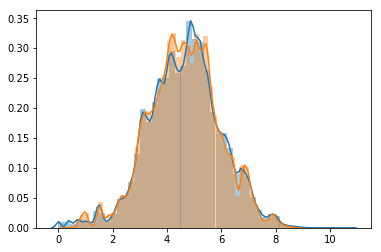

-------------------------------------------------------------
groupNum_train 131 (574174, 77)
cat_features [72, 73, 74, 75, 76]
[ 1  2  3  4  5  6  7  9 10 11]
train 382767 valid 191407
training LGB:


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 20 rounds.
[50]	training's l2: 0.675301	valid_1's l2: 1.28886
[100]	training's l2: 0.501955	valid_1's l2: 1.20262
Early stopping, best iteration is:
[110]	training's l2: 0.488117	valid_1's l2: 1.19964
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.4881167291188711}, 'valid_1': {'l2': 1.199642071114191}})
[ 4  5  6  7  8  9 10 11 12]
train 382783 valid 191391
training LGB:
Training until validation scores don't improve for 20 rounds.
[50]	training's l2: 0.748643	valid_1's l2: 0.944607
[100]	training's l2: 0.544757	valid_1's l2: 0.679694
[150]	training's l2: 0.479604	valid_1's l2: 0.643836
[200]	training's l2: 0.434642	valid_1's l2: 0.625186
Did not meet early stopping. Best iteration is:
[200]	training's l2: 0.434642	valid_1's l2: 0.625186
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.4346421802504279}, 'valid_1': {'l2': 0.6251863085877859}})
[ 8  9 10 11 12]
train 382798 valid 191376
training LGB:
Training 

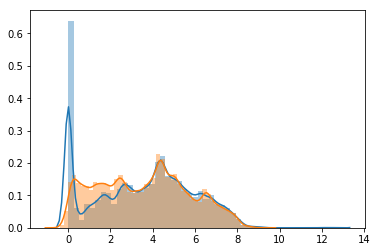

-------------------------------------------------------------
groupNum_train 132 (740199, 77)
cat_features [72, 73, 74, 75, 76]
[1 2 3 4 5 7 8 9]
train 493460 valid 246739
training LGB:


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 20 rounds.
[50]	training's l2: 1.54932	valid_1's l2: 1.68365
[100]	training's l2: 1.24569	valid_1's l2: 1.40122
[150]	training's l2: 1.11089	valid_1's l2: 1.26101
[200]	training's l2: 1.02348	valid_1's l2: 1.24061
Did not meet early stopping. Best iteration is:
[200]	training's l2: 1.02348	valid_1's l2: 1.24061
best_score defaultdict(<class 'dict'>, {'training': {'l2': 1.0234801428661333}, 'valid_1': {'l2': 1.2406089766818382}})
[ 2  3  4  5  6  7  8  9 10 11]
train 493467 valid 246732
training LGB:
Training until validation scores don't improve for 20 rounds.
[50]	training's l2: 1.07817	valid_1's l2: 3.12389
[100]	training's l2: 0.807961	valid_1's l2: 2.7052
[150]	training's l2: 0.708387	valid_1's l2: 2.60547
[200]	training's l2: 0.655874	valid_1's l2: 2.54268
Did not meet early stopping. Best iteration is:
[200]	training's l2: 0.655874	valid_1's l2: 2.54268
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.6558741780733712

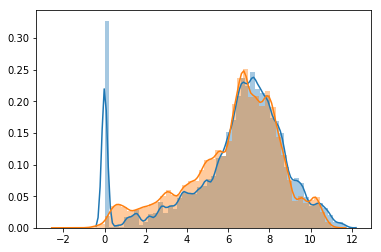

-------------------------------------------------------------
groupNum_train 140 (873333, 77)
cat_features [72, 73, 74, 75, 76]
[1 2 3 4 5 6 7 8]
train 582213 valid 291120
training LGB:


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 20 rounds.
[50]	training's l2: 0.507736	valid_1's l2: 0.31868
[100]	training's l2: 0.322985	valid_1's l2: 0.305921
[150]	training's l2: 0.247012	valid_1's l2: 0.298289
Early stopping, best iteration is:
[165]	training's l2: 0.234369	valid_1's l2: 0.297033
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.23436905469918384}, 'valid_1': {'l2': 0.2970330315541797}})
[ 3  4  5  6  7  8  9 10]
train 582221 valid 291112
training LGB:
Training until validation scores don't improve for 20 rounds.
[50]	training's l2: 0.337702	valid_1's l2: 0.783681
[100]	training's l2: 0.223495	valid_1's l2: 0.757271
[150]	training's l2: 0.172074	valid_1's l2: 0.749544
Early stopping, best iteration is:
[133]	training's l2: 0.187878	valid_1's l2: 0.748758
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.187878355798766}, 'valid_1': {'l2': 0.7487576918818534}})
[ 6  7  8  9 10 11 12]
train 582232 valid 291101
training LGB:
Training until v

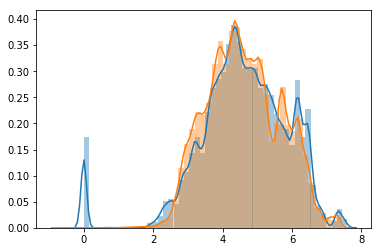

-------------------------------------------------------------
groupNum_train 141 (718263, 77)
cat_features [72, 73, 74, 75, 76]
[1 2 3 4 5 6]
train 478827 valid 239436
training LGB:


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 20 rounds.
[50]	training's l2: 1.5605	valid_1's l2: 2.60813
[100]	training's l2: 1.24398	valid_1's l2: 2.45463
[150]	training's l2: 1.11857	valid_1's l2: 2.41511
Early stopping, best iteration is:
[151]	training's l2: 1.11613	valid_1's l2: 2.4144
best_score defaultdict(<class 'dict'>, {'training': {'l2': 1.116125050501156}, 'valid_1': {'l2': 2.4144006906111293}})
[4 5 6 7 8 9]
train 478842 valid 239421
training LGB:
Training until validation scores don't improve for 20 rounds.
[50]	training's l2: 1.89839	valid_1's l2: 1.71369
[100]	training's l2: 1.52261	valid_1's l2: 1.45302
[150]	training's l2: 1.37538	valid_1's l2: 1.43352
Early stopping, best iteration is:
[135]	training's l2: 1.41108	valid_1's l2: 1.42064
best_score defaultdict(<class 'dict'>, {'training': {'l2': 1.4110833426042309}, 'valid_1': {'l2': 1.4206439551427343}})
[ 7  8  9 10 11 12]
train 478857 valid 239406
training LGB:
Training until validation scores don't improve fo

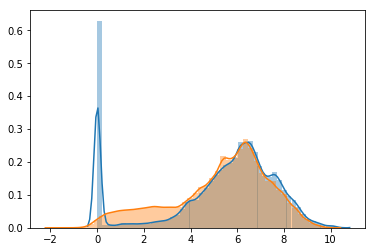

-------------------------------------------------------------
groupNum_train 143 (478463, 77)
cat_features [72, 73, 74, 75, 76]
[1 2 3 4 5 6 7]
train 318964 valid 159499
training LGB:


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 20 rounds.
[50]	training's l2: 2.17921	valid_1's l2: 3.01333
[100]	training's l2: 1.86587	valid_1's l2: 2.87147
Early stopping, best iteration is:
[97]	training's l2: 1.87483	valid_1's l2: 2.86631
best_score defaultdict(<class 'dict'>, {'training': {'l2': 1.8748285404713043}, 'valid_1': {'l2': 2.8663083490990244}})
[ 3  4  5  6  7  8  9 10]
train 318972 valid 159491
training LGB:
Training until validation scores don't improve for 20 rounds.
[50]	training's l2: 2.3149	valid_1's l2: 2.44157
[100]	training's l2: 1.94706	valid_1's l2: 2.1825
[150]	training's l2: 1.79421	valid_1's l2: 2.12029
Early stopping, best iteration is:
[175]	training's l2: 1.73097	valid_1's l2: 2.10356
best_score defaultdict(<class 'dict'>, {'training': {'l2': 1.730971494977214}, 'valid_1': {'l2': 2.1035592846938918}})
[ 8  9 10 11 12]
train 318990 valid 159473
training LGB:
Training until validation scores don't improve for 20 rounds.
[50]	training's l2: 1.94926	va

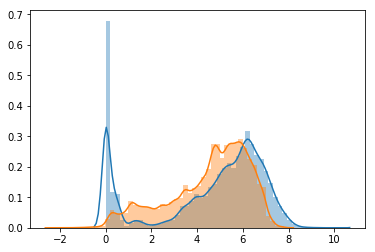

-------------------------------------------------------------
groupNum_train 142 (352906, 77)
cat_features [72, 73, 74, 75, 76]
[1 2 3 4 5 6 7]
train 235262 valid 117644
training LGB:


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 20 rounds.
[50]	training's l2: 1.06222	valid_1's l2: 2.67453
Early stopping, best iteration is:
[30]	training's l2: 1.37073	valid_1's l2: 2.58128
best_score defaultdict(<class 'dict'>, {'training': {'l2': 1.3707328947397694}, 'valid_1': {'l2': 2.581279555991223}})
[ 1  4  5  6  7  8  9 10 12]
train 235271 valid 117635
training LGB:
Training until validation scores don't improve for 20 rounds.
[50]	training's l2: 1.07171	valid_1's l2: 1.3736
[100]	training's l2: 0.820629	valid_1's l2: 1.25357
[150]	training's l2: 0.717973	valid_1's l2: 1.23401
Early stopping, best iteration is:
[155]	training's l2: 0.709707	valid_1's l2: 1.22993
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.7097066326421181}, 'valid_1': {'l2': 1.2299267908928706}})
[ 8  9 10 11 12]
train 235279 valid 117627
training LGB:
Training until validation scores don't improve for 20 rounds.
[50]	training's l2: 0.945129	valid_1's l2: 2.32532
Early stopping, best it

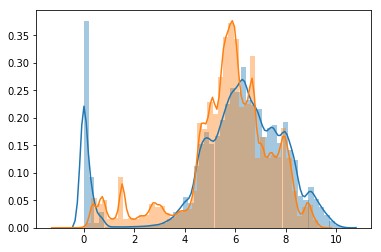

-------------------------------------------------------------
groupNum_train 153 (14797, 77)
cat_features [72, 73, 74, 75, 76]
[1 2 3 4 5 6]
train 9864 valid 4933
training LGB:


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 20 rounds.
[50]	training's l2: 0.137506	valid_1's l2: 0.320295
Early stopping, best iteration is:
[51]	training's l2: 0.13505	valid_1's l2: 0.319734
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.135049506579498}, 'valid_1': {'l2': 0.31973429338339465}})
[5 6 7 8 9]
train 9865 valid 4932
training LGB:
Training until validation scores don't improve for 20 rounds.
[50]	training's l2: 0.11232	valid_1's l2: 0.490911
Early stopping, best iteration is:
[46]	training's l2: 0.124254	valid_1's l2: 0.490183
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.12425353772350722}, 'valid_1': {'l2': 0.49018269936841713}})
[ 9 10 11 12]
train 9865 valid 4932
training LGB:
Training until validation scores don't improve for 20 rounds.
[50]	training's l2: 0.0945626	valid_1's l2: 0.457417
[100]	training's l2: 0.0538362	valid_1's l2: 0.394515
[150]	training's l2: 0.0441099	valid_1's l2: 0.388389
[200]	training's l2: 0.0390363	valid_

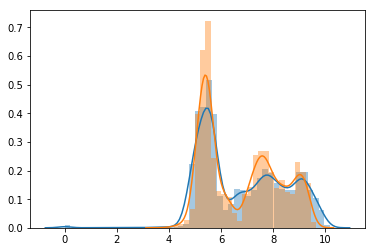

-------------------------------------------------------------
groupNum_train 150 (833085, 77)
cat_features [72, 73, 74, 75, 76]
[ 1  2  3  4  5  6  7  9 10]
train 555353 valid 277732
training LGB:


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 20 rounds.
[50]	training's l2: 0.0714457	valid_1's l2: 0.110923
[100]	training's l2: 0.0426444	valid_1's l2: 0.0933382
[150]	training's l2: 0.032941	valid_1's l2: 0.0883329
[200]	training's l2: 0.0287507	valid_1's l2: 0.087135
Did not meet early stopping. Best iteration is:
[200]	training's l2: 0.0287507	valid_1's l2: 0.087135
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.02875069026709378}, 'valid_1': {'l2': 0.08713495457295102}})
[ 2  3  5  6  7  8  9 10 11]
train 555374 valid 277711
training LGB:
Training until validation scores don't improve for 20 rounds.
[50]	training's l2: 0.0767043	valid_1's l2: 0.11133
[100]	training's l2: 0.045457	valid_1's l2: 0.0847107
[150]	training's l2: 0.0346033	valid_1's l2: 0.0750518
[200]	training's l2: 0.0300364	valid_1's l2: 0.07073
Did not meet early stopping. Best iteration is:
[200]	training's l2: 0.0300364	valid_1's l2: 0.07073
best_score defaultdict(<class 'dict'>, {'training': 

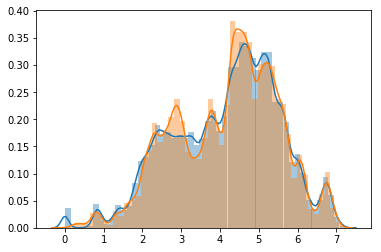

-------------------------------------------------------------
groupNum_train 151 (449642, 77)
cat_features [72, 73, 74, 75, 76]
[ 1  2  3  4  5  6  7 11 12]
train 299752 valid 149890
training LGB:


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 20 rounds.
[50]	training's l2: 0.188052	valid_1's l2: 0.384155
[100]	training's l2: 0.126396	valid_1's l2: 0.334082
[150]	training's l2: 0.107466	valid_1's l2: 0.323405
[200]	training's l2: 0.0973465	valid_1's l2: 0.321236
Did not meet early stopping. Best iteration is:
[200]	training's l2: 0.0973465	valid_1's l2: 0.321236
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.09734654663098095}, 'valid_1': {'l2': 0.321236452157671}})
[ 4  5  6  7  8  9 10 12]
train 299759 valid 149883
training LGB:
Training until validation scores don't improve for 20 rounds.
[50]	training's l2: 0.204985	valid_1's l2: 0.351312
[100]	training's l2: 0.147481	valid_1's l2: 0.218896
[150]	training's l2: 0.126991	valid_1's l2: 0.195697
[200]	training's l2: 0.115054	valid_1's l2: 0.186565
Did not meet early stopping. Best iteration is:
[200]	training's l2: 0.115054	valid_1's l2: 0.186565
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.115

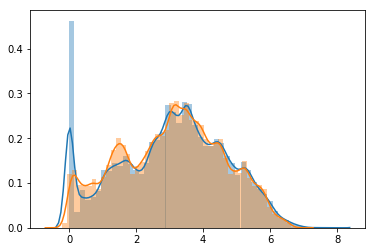

-------------------------------------------------------------
groupNum_train 152 (494111, 77)
cat_features [72, 73, 74, 75, 76]
[ 1  2  3  4  5  6  7  8  9 10 12]
train 329383 valid 164728
training LGB:


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 20 rounds.
[50]	training's l2: 0.742023	valid_1's l2: 0.851309
[100]	training's l2: 0.646118	valid_1's l2: 0.801206
Early stopping, best iteration is:
[123]	training's l2: 0.623248	valid_1's l2: 0.794232
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.623247786182012}, 'valid_1': {'l2': 0.7942324103902241}})
[ 6  7  8  9 10 11 12]
train 329394 valid 164717
training LGB:
Training until validation scores don't improve for 20 rounds.
[50]	training's l2: 0.477636	valid_1's l2: 1.37151
[100]	training's l2: 0.372168	valid_1's l2: 1.29828
[150]	training's l2: 0.335506	valid_1's l2: 1.28303
[200]	training's l2: 0.314302	valid_1's l2: 1.26947
Did not meet early stopping. Best iteration is:
[200]	training's l2: 0.314302	valid_1's l2: 1.26947
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.31430208809676025}, 'valid_1': {'l2': 1.269472641126595}})
[ 9 10 11 12]
train 329445 valid 164666
training LGB:
Training until valid

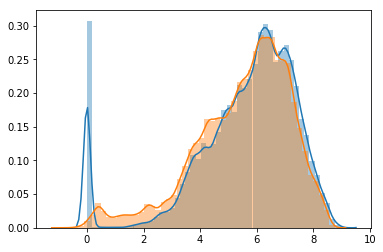

-------------------------------------------------------------


In [67]:
for groupNum_train in building_meta_df['groupNum_train'].unique():
    X_train, y_train = create_X_y(train_df, groupNum_train=groupNum_train)
    y_valid_pred_total = np.zeros(X_train.shape[0])
    gc.collect()
    print('groupNum_train', groupNum_train, X_train.shape)

    cat_features = [X_train.columns.get_loc(cat_col) for cat_col in category_cols]
    print('cat_features', cat_features)

    exec('models' +str(groupNum_train)+ '=[]')

    train_df_site = train_df[train_df['groupNum_train']==groupNum_train].copy()
    
    #for train_idx, valid_idx in kf.split(X_train, y_train):
    #for train_idx, valid_idx in kf.split(X_train, y_train, groups=get_groups(train_df, groupNum_train)):    
    for train_idx, valid_idx in kf.split(train_df_site, train_df_site['building_id']):
        train_data = X_train.iloc[train_idx,:], y_train[train_idx]
        valid_data = X_train.iloc[valid_idx,:], y_train[valid_idx]

        mindex = train_df_site.iloc[valid_idx,:].month.unique()
        print (mindex)

        print('train', len(train_idx), 'valid', len(valid_idx))
    #     model, y_pred_valid, log = fit_cb(train_data, valid_data, cat_features=cat_features, devices=[0,])
        model, y_pred_valid, log = fit_lgbm(train_data, valid_data, cat_features=category_cols,
                                            num_rounds=num_rounds, lr=0.05, bf=0.7)
        y_valid_pred_total[valid_idx] = y_pred_valid
        exec('models' +str(groupNum_train)+ '.append([mindex, model])')        
        gc.collect()
        if debug:
            break

    try:
        sns.distplot(y_train)
        sns.distplot(y_valid_pred_total)
        plt.show()
    except:
        pass

    del X_train, y_train
    gc.collect()
    
    print('-------------------------------------------------------------')

In [68]:
del train_df
gc.collect()

0

# Prediction on test data

In [69]:
print('loading...')
test_df = pd.read_feather(root/'test.feather')
weather_test_df = pd.read_feather(root/'weather_test.feather')

weather_test_df = weather_test_df.drop_duplicates(['timestamp', 'site_id'])
set_local(weather_test_df)
add_holiyday(weather_test_df)

print('preprocessing building...')
test_df['date'] = test_df['timestamp'].dt.date
preprocess(test_df)
#test_df['building_median'] = test_df['building_id'].map(building_median)

print('preprocessing weather...')
weather_test_df = weather_test_df.groupby('site_id').apply(lambda group: group.interpolate(limit_direction='both'))
weather_test_df.groupby('site_id').apply(lambda group: group.isna().sum())

add_sg(weather_test_df)

add_lag_feature(weather_test_df, window=3)
add_lag_feature(weather_test_df, window=72)

#bid_map = train_df.building_id.value_counts()
test_df['bid_cnt'] = test_df.building_id.map(bid_map)

test_df = test_df.merge(building_meta_df[['building_id','meter','groupNum_train']], on=['building_id','meter'], how='left')
              
print('reduce mem usage...')
test_df = reduce_mem_usage(test_df, use_float16=True)
weather_test_df = reduce_mem_usage(weather_test_df, use_float16=True)

gc.collect()
print (test_df.shape)

loading...


/opt/conda/lib/python3.6/site-packages/pandas/io/feather_format.py:117: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_feather(path, columns=columns, nthreads=int_use_threads)
/opt/conda/lib/python3.6/site-packages/pyarrow/pandas_compat.py:751: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


preprocessing building...
preprocessing weather...
reduce mem usage...
Memory usage of dataframe is 3221.04 MB
Memory usage after optimization is: 1352.07 MB
Decreased by 58.0%
Memory usage of dataframe is 54.47 MB
Memory usage after optimization is: 41.51 MB
Decreased by 23.8%
(41697600, 12)


In [70]:
sample_submission = pd.read_feather(os.path.join(root, 'sample_submission.feather'))
reduce_mem_usage(sample_submission)

print(sample_submission.shape)

/opt/conda/lib/python3.6/site-packages/pandas/io/feather_format.py:117: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_feather(path, columns=columns, nthreads=int_use_threads)
/opt/conda/lib/python3.6/site-packages/pyarrow/pandas_compat.py:751: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


Memory usage of dataframe is 636.26 MB
Memory usage after optimization is: 198.83 MB
Decreased by 68.7%
(41697600, 2)


In [71]:
def create_X(test_df, groupNum_train):
    
    target_test_df = test_df[test_df['groupNum_train'] == groupNum_train].copy()        
    target_test_df = target_test_df.merge(df_groupNum_median, on=['timestamp'], how='left')
    target_test_df = target_test_df.merge(building_meta_df, on=['building_id','meter','groupNum_train'], how='left')
    target_test_df = target_test_df.merge(weather_test_df, on=['site_id', 'timestamp'], how='left')
    target_test_df['group_median_'+str(groupNum_train)] = np.nan

    X_test = target_test_df[feature_cols + category_cols]
    
    return X_test

In [72]:
def pred_all(X_test, models, batch_size=1000000):
    iterations = (X_test.shape[0] + batch_size -1) // batch_size
    print('iterations', iterations)

    y_test_pred_total = np.zeros(X_test.shape[0])
    for i, (mindex, model) in enumerate(models):
        print(f'predicting {i}-th model')
        for k in tqdm(range(iterations)):
            y_pred_test = model.predict(X_test[k*batch_size:(k+1)*batch_size], num_iteration=model.best_iteration)
            y_test_pred_total[k*batch_size:(k+1)*batch_size] += y_pred_test

    y_test_pred_total /= len(models)
    return y_test_pred_total


def pred(X_test, models, batch_size=1000000):
    if predmode == 'valid':
        print ('valid pred')
        return pred_valid(X_test, models, batch_size=1000000)
    elif predmode == 'train':
        print ('train pred')
        return pred_train(X_test, models, batch_size=1000000)
    else:
        print ('all pred')
        return pred_all(X_test, models, batch_size=1000000)

groupNum_train:  0
all pred
iterations 2
predicting 0-th model



predicting 1-th model



predicting 2-th model


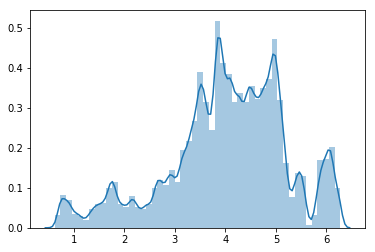

(1839600, 77) (1839600,)
groupNum_train:  1
all pred
iterations 1
predicting 0-th model



predicting 1-th model



predicting 2-th model


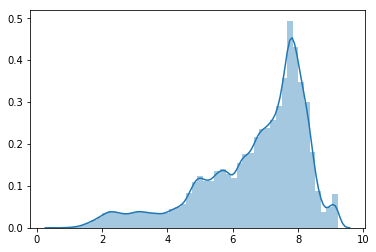

(420480, 77) (420480,)
groupNum_train:  10
all pred
iterations 1
predicting 0-th model



predicting 1-th model



predicting 2-th model


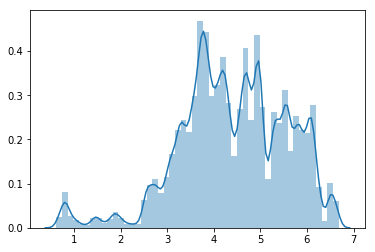

(893520, 77) (893520,)
groupNum_train:  13
all pred
iterations 1
predicting 0-th model



predicting 1-th model



predicting 2-th model


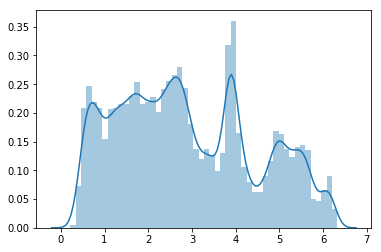

(210240, 77) (210240,)
groupNum_train:  20
all pred
iterations 3
predicting 0-th model



predicting 1-th model



predicting 2-th model


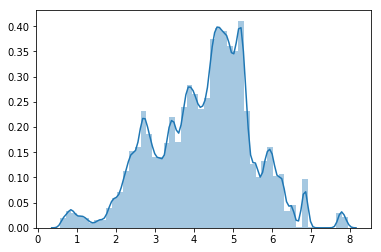

(2365200, 77) (2365200,)
groupNum_train:  21
all pred
iterations 2
predicting 0-th model



predicting 1-th model



predicting 2-th model


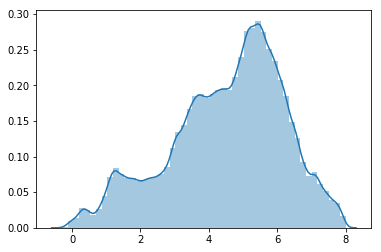

(1734480, 77) (1734480,)
groupNum_train:  23
all pred
iterations 1
predicting 0-th model



predicting 1-th model



predicting 2-th model


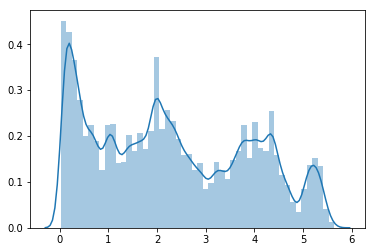

(963600, 77) (963600,)
groupNum_train:  30
all pred
iterations 5
predicting 0-th model



predicting 1-th model



predicting 2-th model


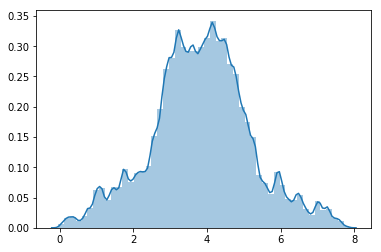

(4800480, 77) (4800480,)
groupNum_train:  40
all pred
iterations 2
predicting 0-th model



predicting 1-th model



predicting 2-th model


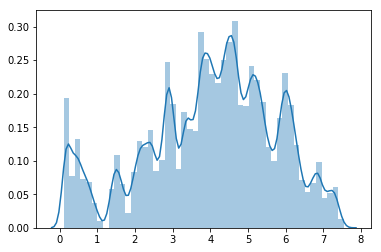

(1594320, 77) (1594320,)
groupNum_train:  50
all pred
iterations 2
predicting 0-th model



predicting 1-th model



predicting 2-th model


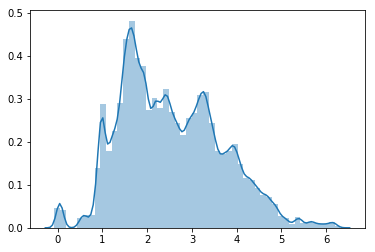

(1559280, 77) (1559280,)
groupNum_train:  60
all pred
iterations 1
predicting 0-th model



predicting 1-th model



predicting 2-th model


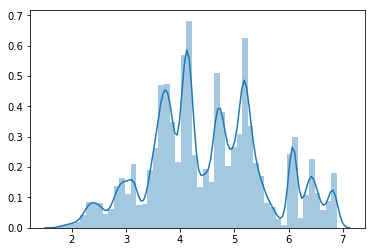

(630720, 77) (630720,)
groupNum_train:  62
all pred
iterations 1
predicting 0-th model



predicting 1-th model



predicting 2-th model


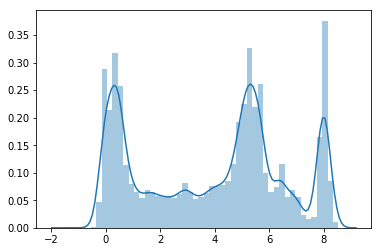

(402960, 77) (402960,)
groupNum_train:  61
all pred
iterations 1
predicting 0-th model



predicting 1-th model



predicting 2-th model


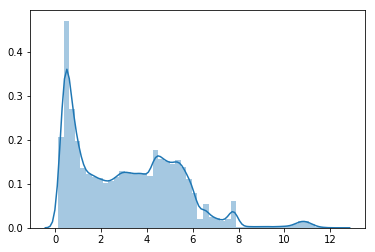

(367920, 77) (367920,)
groupNum_train:  71
all pred
iterations 1
predicting 0-th model



predicting 1-th model



predicting 2-th model


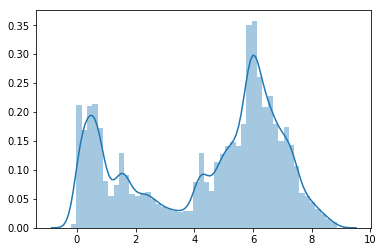

(262800, 77) (262800,)
groupNum_train:  72
all pred
iterations 1
predicting 0-th model



predicting 1-th model



predicting 2-th model


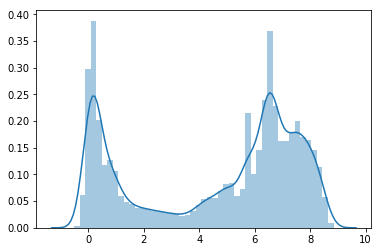

(210240, 77) (210240,)
groupNum_train:  70
all pred
iterations 1
predicting 0-th model



predicting 1-th model



predicting 2-th model


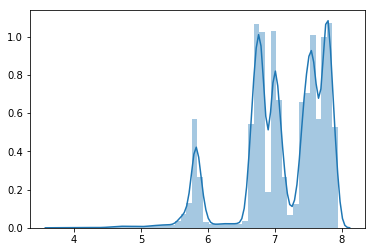

(210240, 77) (210240,)
groupNum_train:  73
all pred
iterations 1
predicting 0-th model



predicting 1-th model



predicting 2-th model


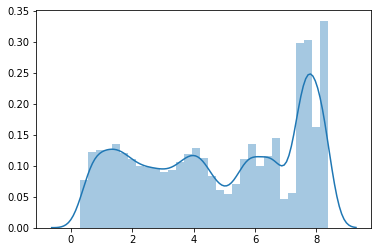

(52560, 77) (52560,)
groupNum_train:  80
all pred
iterations 2
predicting 0-th model



predicting 1-th model



predicting 2-th model


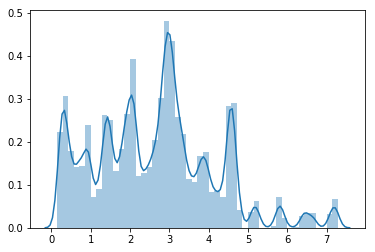

(1226400, 77) (1226400,)
groupNum_train:  90
all pred
iterations 3
predicting 0-th model



predicting 1-th model



predicting 2-th model


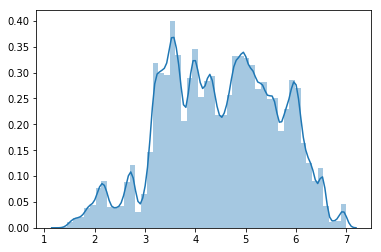

(2137440, 77) (2137440,)
groupNum_train:  91
all pred
iterations 2
predicting 0-th model



predicting 1-th model



predicting 2-th model


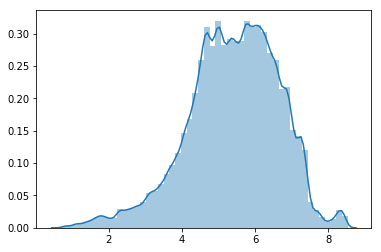

(1664400, 77) (1664400,)
groupNum_train:  92
all pred
iterations 2
predicting 0-th model



predicting 1-th model



predicting 2-th model


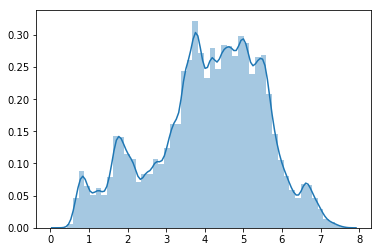

(1559280, 77) (1559280,)
groupNum_train:  100
all pred
iterations 1
predicting 0-th model



predicting 1-th model



predicting 2-th model


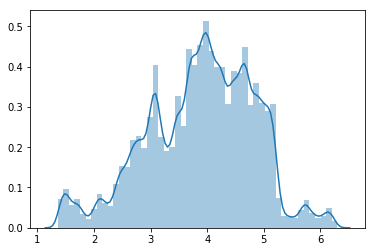

(525600, 77) (525600,)
groupNum_train:  101
all pred
iterations 1
predicting 0-th model



predicting 1-th model



predicting 2-th model


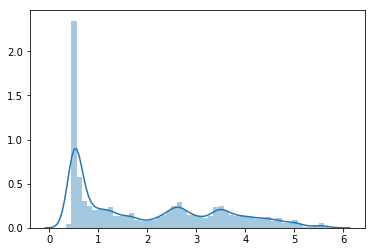

(157680, 77) (157680,)
groupNum_train:  103
all pred
iterations 1
predicting 0-th model



predicting 1-th model



predicting 2-th model


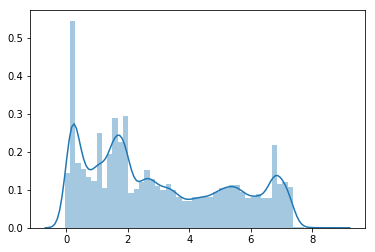

(192720, 77) (192720,)
groupNum_train:  110
all pred
iterations 1
predicting 0-th model



predicting 1-th model



predicting 2-th model


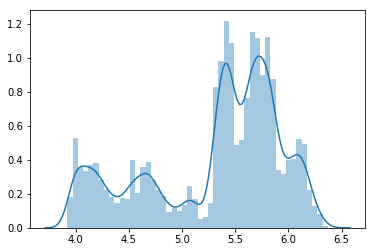

(87600, 77) (87600,)
groupNum_train:  111
all pred
iterations 1
predicting 0-th model



predicting 1-th model



predicting 2-th model


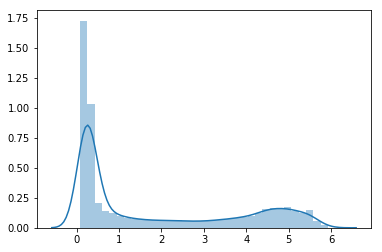

(70080, 77) (70080,)
groupNum_train:  113
all pred
iterations 1
predicting 0-th model



predicting 1-th model



predicting 2-th model


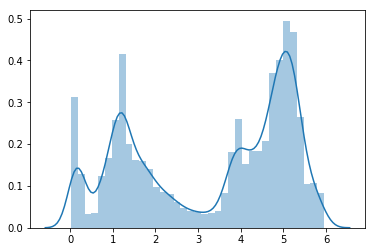

(87600, 77) (87600,)
groupNum_train:  120
all pred
iterations 1
predicting 0-th model



predicting 1-th model



predicting 2-th model


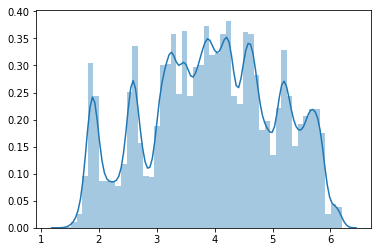

(630720, 77) (630720,)
groupNum_train:  130
all pred
iterations 3
predicting 0-th model



predicting 1-th model



predicting 2-th model


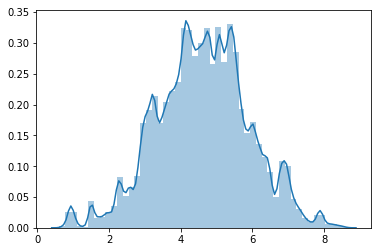

(2470320, 77) (2470320,)
groupNum_train:  131
all pred
iterations 2
predicting 0-th model



predicting 1-th model



predicting 2-th model


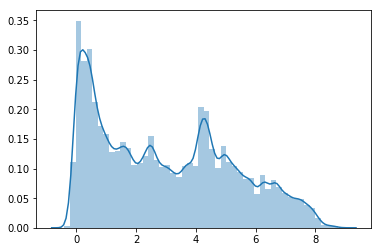

(1401600, 77) (1401600,)
groupNum_train:  132
all pred
iterations 2
predicting 0-th model



predicting 1-th model



predicting 2-th model


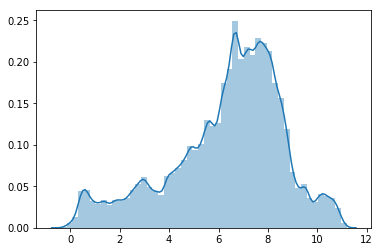

(1541760, 77) (1541760,)
groupNum_train:  140
all pred
iterations 2
predicting 0-th model



predicting 1-th model



predicting 2-th model


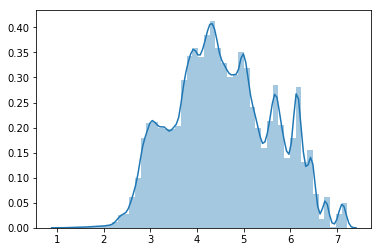

(1787040, 77) (1787040,)
groupNum_train:  141
all pred
iterations 2
predicting 0-th model



predicting 1-th model



predicting 2-th model


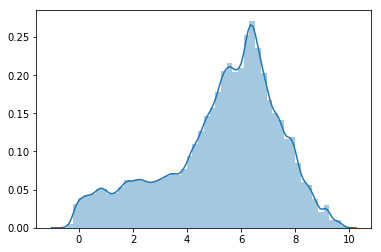

(1506720, 77) (1506720,)
groupNum_train:  143
all pred
iterations 1
predicting 0-th model



predicting 1-th model



predicting 2-th model


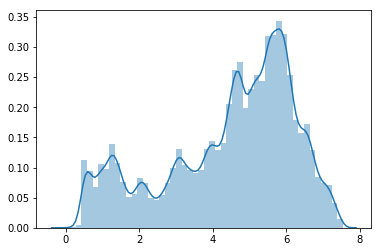

(998640, 77) (998640,)
groupNum_train:  142
all pred
iterations 1
predicting 0-th model



predicting 1-th model



predicting 2-th model


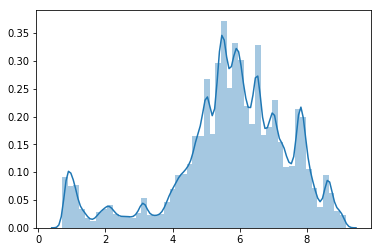

(753360, 77) (753360,)
groupNum_train:  153
all pred
iterations 1
predicting 0-th model



predicting 1-th model



predicting 2-th model


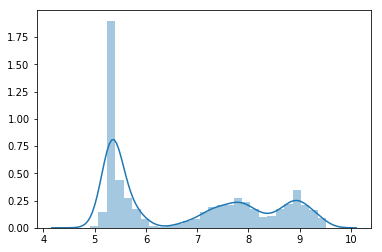

(35040, 77) (35040,)
groupNum_train:  150
all pred
iterations 2
predicting 0-th model



predicting 1-th model



predicting 2-th model


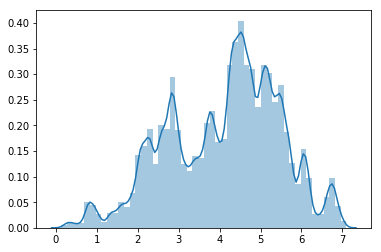

(1997280, 77) (1997280,)
groupNum_train:  151
all pred
iterations 2
predicting 0-th model



predicting 1-th model



predicting 2-th model


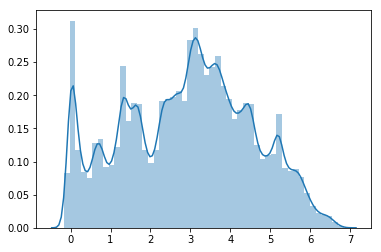

(1138800, 77) (1138800,)
groupNum_train:  152
all pred
iterations 2
predicting 0-th model



predicting 1-th model



predicting 2-th model


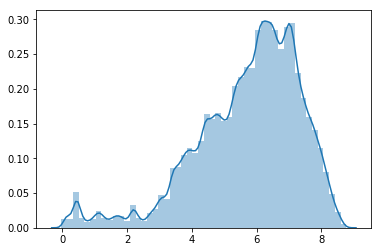

(1208880, 77) (1208880,)


In [73]:
for groupNum_train in building_meta_df['groupNum_train'].unique():
    print('groupNum_train: ', groupNum_train)
    X_test = create_X(test_df, groupNum_train=groupNum_train)
    gc.collect()

    exec('y_test= pred(X_test, models' +str(groupNum_train)+ ')')

    sns.distplot(y_test)
    plt.show()

    print(X_test.shape, y_test.shape)
    sample_submission.loc[test_df["groupNum_train"] == groupNum_train,"meter_reading"] = np.expm1(y_test)
    
    del X_test, y_test
    gc.collect()

# site-0 correction 

In [74]:
# https://www.kaggle.com/c/ashrae-energy-prediction/discussion/119261#latest-684102
sample_submission.loc[(test_df.building_id.isin(site_0_bids)) & (test_df.meter==0), 'meter_reading'] = sample_submission[(test_df.building_id.isin(site_0_bids)) & (test_df.meter==0)]['meter_reading'] * 3.4118

In [75]:
if rescale:   
    sample_submission.loc[(test_df.building_id == 778) & (test_df.meter == 1), 'meter_reading'] = 100 * sample_submission.loc[(test_df.building_id == 778) & (test_df.meter == 1), 'meter_reading']
    sample_submission.loc[(test_df.building_id == 1021) & (test_df.meter == 3), 'meter_reading'] = 1000 * sample_submission.loc[(test_df.building_id == 1021) & (test_df.meter == 3), 'meter_reading']
    
    plt.figure()
    plt.subplot(211)
    sample_submission.loc[(test_df.building_id == 778) & (test_df.meter == 1), 'meter_reading'].plot()
    plt.subplot(212)    
    sample_submission.loc[(test_df.building_id == 1021) & (test_df.meter == 3), 'meter_reading'].plot()

In [76]:
if clip0:
    sample_submission.loc[sample_submission.meter_reading < 0, 'meter_reading'] = 0

In [77]:
if not debug:
    sample_submission.to_csv('submission_no_leak.csv', index=False, float_format='%.4f')

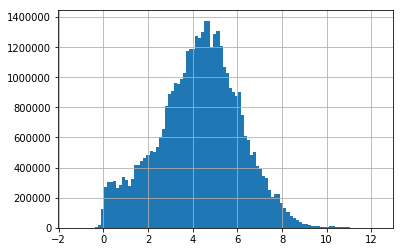

In [78]:
np.log1p(sample_submission['meter_reading']).hist(bins=100)

# replace LEAK data

In [79]:
# i'm now using my leak data station kernel to shortcut.
leak_df = pd.read_feather('../input/ashrae-leak-data-station/leak.feather')

print(leak_df.duplicated().sum())
print(leak_df.meter.value_counts())

leak_df.fillna(0, inplace=True)
leak_df = leak_df[(leak_df.timestamp.dt.year > 2016) & (leak_df.timestamp.dt.year < 2019)]
leak_df.loc[leak_df.meter_reading < 0, 'meter_reading'] = 0 # remove large negative values
leak_df = leak_df[leak_df.building_id!=245]

sample_submission.loc[sample_submission.meter_reading < 0, 'meter_reading'] = 0

test_df['pred'] = sample_submission.meter_reading

leak_df = leak_df.merge(test_df[['building_id', 'meter', 'timestamp', 'pred', 'row_id']], left_on = ['building_id', 'meter', 'timestamp'], right_on = ['building_id', 'meter', 'timestamp'], how = "left")
leak_df = leak_df.merge(building_meta_df[['building_id', 'site_id']].drop_duplicates(), on='building_id', how='left')

0
0.0    10747350
1.0     3879538
3.0     1445555
2.0      727682
Name: meter, dtype: int64


In [80]:
leak_df.site_id.unique()

array([ 0,  1,  2,  4, 15])

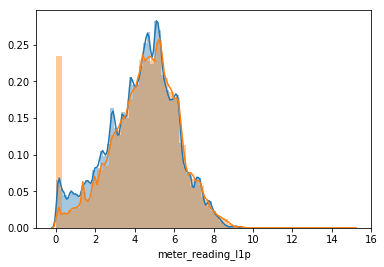

In [81]:
leak_df['pred_l1p'] = np.log1p(leak_df.pred)
leak_df['meter_reading_l1p'] = np.log1p(leak_df.meter_reading)

sns.distplot(leak_df.pred_l1p)
sns.distplot(leak_df.meter_reading_l1p)

leak_score = np.sqrt(mean_squared_error(leak_df.pred_l1p, leak_df.meter_reading_l1p))

In [82]:
leak_df = leak_df[['meter_reading', 'row_id']].set_index('row_id').dropna()
sample_submission.loc[leak_df.index, 'meter_reading'] = leak_df['meter_reading']

In [83]:
sample_submission.head()

,row_id,meter_reading
0,0,173.370293
1,1,53.512720
2,2,6.143042
3,3,101.701470
4,4,1141.240666


In [84]:
if not debug:
    sample_submission.to_csv('submission.csv', index=False, float_format='%.4f')

In [85]:
sample_submission.tail()

,row_id,meter_reading
41697595,41697595,6.875436
41697596,41697596,4.336694
41697597,41697597,3.100692
41697598,41697598,163.926864
41697599,41697599,3.228847


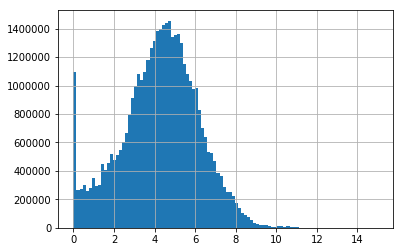

In [86]:
np.log1p(sample_submission['meter_reading']).hist(bins=100)

# Scores

In [87]:
print('LV score=', leak_score)

LV score= 0.9667082533613954


# References

These kernels inspired me to write this kernel, thank you for sharing!

 - https://www.kaggle.com/rishabhiitbhu/ashrae-simple-eda
 - https://www.kaggle.com/isaienkov/simple-lightgbm
 - https://www.kaggle.com/ryches/simple-lgbm-solution